# E-commerce - Cегментация покупателей по профилю потребления

Ссылка на презентацию:

https://drive.google.com/file/d/1hNubSGkEqUeZ8PxmgPF4y6rOpeHwrxh6/view?usp=sharing



Ссылка на дашбоард:

https://public.tableau.com/shared/RCGBS79CG?:display_count=n&:origin=viz_share_link

<b> Заказчик: </b>

Менеджер продукта, отвечающий за пользовательский опыт

<b> Цель: </b>

Провести aнализ и сегментацию покупателей на основе истории их покупок для интернет-магазина товаров для дома и быта «Пока все ещё тут», а также сформулировать рекомендации.


<b> Описание данных: </b>

Датасет описывает транзакции интернет-магазина товаров для дома и быта «Пока все ещё тут».

Колонки:

* *date* — дата заказа;
* *customer_id* — идентификатор покупателя;
* *order_id*  — идентификатор заказа;
* *product* — наименование товара;
* *quantity*  — количество товара в заказе;
* *price* — цена товара.

<b> Задачи: </b>

1. Открыть файл с данными и изучить общую информацию.
2. Подготовить данные.
    - Проверить наличие дубликатов и пропусков.
    - Проверить данные на аномалии (оптовые заказы, наличие у одного номера заказа единственного номера покупателя).
    - Проверить типы данных. Откорректировать при необходимости.
    - Добавить столбец hour, в котором будет указан конкретный час, в который был сделан заказ.
    - Добавить столбец weekday, в котором будет указан день недели заказа.
    - Добавить столбец month, с месяцем заказа.
    - Добавить столбец year, с годом заказа, чтобы учитывать его при анализе месяца продажи.
    - Выделить товары в отдельные категории (около 7-8). Выделить первые слова и смотреть по ним.
    
    

3. Провести исследовательский анализ.
   - Определить количество покупателей
   - Определить количество заказов
   - Определить количество уникальных товаров
   - Определить среднюю цену одного товара
   - Определить среднее количество заказов на одного покупателя
   - Проанализировать в какие часы, дни недели и месяца происходит больше всего заказов.
   - Определить максимальную и минимальную даты. Построить гистограмму по дате и времени.


4. Поделить ассортимент на 3 группы в зависимости от выручки и количества продаж:
   - "A" - высокая выручка, большое количество продаж;
   - "B" - средняя выручка, среднее количество продаж;
   - "C" - малая выручка, малое количество продаж.
   - Основной ассортимент: "AA", "AB", "BA", "AC", "CA".
   - Дополнительный ассортимент: "BB", "BC", "CB", "CC".

In [1]:
#импортируем библиотеки
    
import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import plotly.express as px
import warnings; warnings.filterwarnings(action='ignore')
from datetime import timedelta, datetime

import math
import scipy.stats as stats
from scipy import stats as st
from sklearn.impute import KNNImputer
from plotly import graph_objects as go


In [2]:
import matplotlib
%config InlineBackend.figure_format = 'retina'  #для более красивых графиков. Нужно один раз запустить в начале проекта
matplotlib.style.use('ggplot')
plt.rc('figure', figsize=(10, 6))

In [3]:
# снимаем ограничение на количество столбцов
pd.set_option('display.max_columns', None)

# снимаем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', None)

# игнорируем предупреждения
pd.set_option('chained_assignment', None)


In [4]:
#Прочитаем датайфрейм:

try:
    df = pd.read_csv('/datasets/ecom_dataset_upd.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/ecom_dataset_upd.csv')

In [5]:
data_row = df

In [6]:
# напишем функцию для обзора данных:

def df_review(df):
    display(df.head(10))
    print('---------------------------------------------------------------------------------------------------------')
    print(df.info())
    print('---------------------------------------------------------------------------------------------------------')
    print(df.describe())
    print('---------------------------------------------------------------------------------------------------------')
    print('Обнаружено дубликатов:', df.duplicated().sum())

In [7]:
df_review(df)


date                           customer_id  order_id  \
0  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
5  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
6  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
7  2018100108  375e0724-f033-4c76-b579-84969cf38ee2     68479   
8  2018100108  6644e5b4-9934-4863-9778-aaa125207701     68478   
9  2018100109  c971fb21-d54c-4134-938f-16b62ee86d3b     68480   

                                                                    product  \
0                           Комнатное растение в горшке Алое Вера, d12, h30   
1                        Комнатное растение в горшке Кофе Арабика, d12, h25   
2                                               Радермахера d-12 см h-20 см   
3                                          Хризолидокарпус Лутесценс d-9 см   
4                                            Циперус Зумула d-12 см h-25 см   
5                                                   Шеффлера Лузеана d-9 см   
6                                          Юкка нитчатая d-12 см h-25-35 см   
7                           Настенная сушилка для белья Gimi Brio Super 100   
8                  Таз пластмассовый 21,0 л круглый "Водолей" С614, 1404056   
9  Чехол для гладильной доски Colombo Persia Beige 130х50 см из хлопка 5379   

   quantity  price  
0         1  142.0  
1         1  194.0  
2         1  112.0  
3         1  179.0  
4         1  112.0  
5         1  164.0  
6         1  134.0  
7         1  824.0  
8         1  269.0  
9         1  674.0

---------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB
None
---------------------------------------------------------------------------------------------------------
               date       order_id     quantity         price
count  7.474000e+03    7474.000000  7474.000000   7474.000000
mean   2.018913e+09   49449.884265     2.362858    478.737501
std    4.278878e+05   32679.642404    14.500497    901.615895
min    2.018100e+09   12624.0

Проверим наличие явных дубликатов  без учета даты.



In [8]:
(
    df[['customer_id', 'order_id', 'product', 'price']]
    .loc[df[['customer_id', 'order_id', 'product', 'price']].duplicated()]
)

customer_id  order_id  \
58    b731df05-98fa-4610-8496-716ec530a02c     68474   
59    b731df05-98fa-4610-8496-716ec530a02c     68474   
60    b731df05-98fa-4610-8496-716ec530a02c     68474   
63    b731df05-98fa-4610-8496-716ec530a02c     68474   
94    32de7df8-8d4f-4c84-a7b9-c41d00dd83ba     68522   
...                                    ...       ...   
6706  57cc80a2-2610-4eef-9457-e7c3bf0c72f0     70960   
6711  cb65d08a-dae7-4890-aef0-bb9f79055e02     73108   
6728  ffaeab76-3a8d-49ee-860f-17273b2fc8a2     73136   
6729  ffaeab76-3a8d-49ee-860f-17273b2fc8a2     73136   
6736  344aa778-e436-419e-a9c6-9b8f37b7c1df     73137   

                                                                          product  \
58    Доска гладильная Eurogold Professional 130х48 см металлическая сетка 35748W   
59    Доска гладильная Eurogold Professional 130х48 см металлическая сетка 35748W   
60    Доска гладильная Eurogold Professional 130х48 см металлическая сетка 35748W   
63    Доска гладильная Eurogold Professional 130х48 см металлическая сетка 35748W   
94                                                 Эвкалипт Гунни d-17 см h-60 см   
...                                                                           ...   
6706                                 Сумка-тележка 2-х колесная Gimi Argo красная   
6711                                                          Мирт d-9 см h-15 см   
6728                         Таз пластмассовый со стиральной доской (Иж), 1404021   
6729                         Таз пластмассовый со стиральной доской (Иж), 1404021   
6736                                   Сумка-тележка 2-х колесная Gimi Argo синяя   

       price  
58    3299.0  
59    3299.0  
60    3299.0  
63    3299.0  
94    1409.0  
...      ...  
6706  1087.0  
6711   134.0  
6728   397.0  
6729   397.0  
6736  1087.0  

[1884 rows x 4 columns]

Tаких строк оказалось 1884. Удалим дубликаты.



In [9]:
df = (
    df
    .drop_duplicates(subset=['customer_id', 'order_id', 'product', 'price'])
    .reset_index(drop=True)
)

Приведем названия товаров к общему виду: заменим буквы на строчные, а также букву "ё" на "е".

In [10]:
df['product'] = df['product'].str.lower()
df['product'] = df['product'].replace('ё', 'е', regex=True)

In [11]:
# Формат даты нужно изменить
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5590 entries, 0 to 5589
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5590 non-null   datetime64[ns]
 1   customer_id  5590 non-null   object        
 2   order_id     5590 non-null   int64         
 3   product      5590 non-null   object        
 4   quantity     5590 non-null   int64         
 5   price        5590 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 262.2+ KB


In [12]:
# посчитаем количество уникальных покупателей в каждом заказе
abnormal_orders = (
    df
    .groupby('order_id', as_index=False)['customer_id']
    .nunique()
    .rename(columns={'customer_id':'nunique'})
    .sort_values(by='nunique', ascending=False)
)
abnormal_orders = abnormal_orders.query('nunique > 1')
print('Абсолютное количество аномальных заказов:', abnormal_orders['order_id'].count())


Абсолютное количество аномальных заказов: 29


Всего таких заказов 29  их можно  убрать и это не сильно повлияет на анализ. Такие заказы могли получиться вследствие технических ошибок.

Yберем строки с аномальными заказами из данных

In [13]:
abnormal_orders_id = abnormal_orders['order_id']
df = df.query('order_id not in @abnormal_orders_id')

Данные извлечены и готовы к анализу. Пропусков не обнаружено, дубликаты удалены. Типы данных приведены к требуемым.

## Исследовательский анализ данных
### Работа с выбросами


In [14]:
df.describe()

order_id     quantity         price
count    5524.000000  5524.000000   5524.000000
mean    55932.132151     2.576937    531.445707
std     32497.263407    16.503629    975.114652
min     12624.000000     1.000000      9.000000
25%     14808.000000     1.000000     90.000000
50%     69191.000000     1.000000    150.000000
75%     71939.500000     1.000000    524.000000
max    112789.000000  1000.000000  14917.000000

В среднем в заказе по 2-3 единицы товара при цене 531 уе.
В 75% заказов покупают 1 единицу продукции при цене не более 524 уе.
Максимальные значения кратно больше - 1000 единиц товара в заказе и стоиомость 14917 уе.


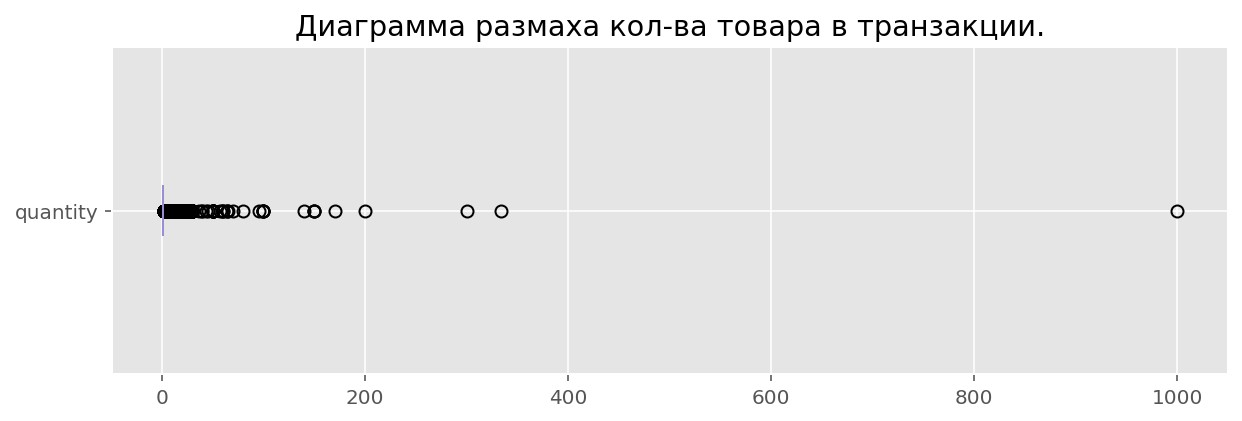

In [15]:
#Посмотрим распределение количества товаров в заказах
df.boxplot(column='quantity', figsize = (10,3), vert = False)
plt.title('Диаграмма размаха кол-ва товара в транзакции.')
plt.show()

Пользователи могут совершать несколько заказов и в заказах может быть по нескольку товаров, что абсолютно логично.



In [16]:
#Посмотрим 95,97 и 99 перцентили по количеству товаров
percentiles = np.percentile(df['quantity'], [95, 97, 99])
print('Перцентили:\n95: {} \n97: {} \n99: {}'.format(percentiles[0].round(),percentiles[1].round(),percentiles[2].round()))

Перцентили:
95: 6.0 
97: 10.0 
99: 26.0


Как видим, в 99% заказов количество товара одного наименования не превышает 26 штук.

In [17]:
#верхняя граница количества заказов
upper_quantity = np.percentile(df['quantity'],99)

#пользователи с количеством позиций больше верхней границы
customer_to_drop = df.query('quantity>@upper_quantity')['customer_id']
df = df.query('customer_id not in @customer_to_drop')
df.head()

date                           customer_id  order_id  \
0 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   

                                              product  quantity  price  
0     комнатное растение в горшке алое вера, d12, h30         1  142.0  
1  комнатное растение в горшке кофе арабика, d12, h25         1  194.0  
2                         радермахера d-12 см h-20 см         1  112.0  
3                    хризолидокарпус лутесценс d-9 см         1  179.0  
4                      циперус зумула d-12 см h-25 см         1  112.0

In [18]:
print(f'Строк до удаления - {len(data_row)}, после - {len(df)}, потеряли {round(100 - (len(df)/len(data_row)*100),2)} %')
print(f'Уникальных пользователей до удаления - {data_row["customer_id"].nunique()}, после - {df["customer_id"].nunique()}, потеряли {round(100 - (df["customer_id"].nunique()/data_row["customer_id"].nunique()*100),2)} %')
print(f'Уникальных заказов до удаления - {data_row["order_id"].nunique()}, после - {df["order_id"].nunique()}, потеряли {round(100 - (df["order_id"].nunique()/data_row["order_id"].nunique()*100),2)} %')


Строк до удаления - 7474, после - 5273, потеряли 29.45 %
Уникальных пользователей до удаления - 2451, после - 2362, потеряли 3.63 %
Уникальных заказов до удаления - 3521, после - 3275, потеряли 6.99 %


В результате преобработки данных столбец date был приведен к специальному типу данных datetime.

Из анализа исключены строки-дубликаты по всем столбцам кроме даты (сохранена последняя строка).

Из анализа исключены пользователи, для которых order_id был не уникальным (то есть order_id повторялся для разных пользователей).


Таким образом, в результате преобработки данных из рассмотрения было исключено 29.45% строк (было строк - 7474, стало - 5273), 3,63% уникальных пользователей и 6.99% уникальных заказов.

### Оценка временной динамики

Добавим столбцы month, year, посмотрим, данными за какой период мы располагаем и оценим необходимость корректировки данных.


In [19]:
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
#df['order_date'] = df['date'].dt.date


In [20]:
print(df['date'].min())
print(df['date'].max())

2018-10-01 00:00:00
2020-01-31 15:00:00


### Добавление столбца revenue

In [21]:
#Посчитаем выручку по товару, добавим новый столбец
df['revenue'] = df['price'] * df['quantity']

In [22]:
df.describe()


order_id     quantity         price        month         year  \
count    5273.000000  5273.000000   5273.000000  5273.000000  5273.000000   
mean    55283.438650     1.683103    523.149456     6.590176  2018.852266   
std     33121.564514     2.443654    973.319953     3.574626     0.477473   
min     12624.000000     1.000000      9.000000     1.000000  2018.000000   
25%     14791.000000     1.000000     90.000000     4.000000  2019.000000   
50%     69178.000000     1.000000    150.000000     6.000000  2019.000000   
75%     72044.000000     1.000000    488.000000    10.000000  2019.000000   
max    112789.000000    25.000000  14917.000000    12.000000  2020.000000   

            revenue  
count   5273.000000  
mean     631.061524  
std     1160.682816  
min        9.000000  
25%      119.000000  
50%      188.000000  
75%      674.000000  
max    24370.000000

Выручка имеет значение от 9 до 675000 уе.
Среднее медианное значение 830, при том как 50% показывают всего лишь 190%, это значит, что преимущественно продается более дешевый товар.

### Категоризация товaров по наименованию

Выделим категории товаров. Для этого посмотрим, какие товары стоят дороже, чаще попадали в заказ, приносили больше выручки, продавались больше по количеству единиц.


In [23]:
# Tаблица продаж по товарам
categories = df.pivot_table(index=['product'], values=['revenue', 'price', 'quantity', 'month'], 
                    aggfunc={'revenue': 'sum', 
                             'price': 'mean', 
                             'quantity': 'sum',
                             'month': 'count'}).round().sort_values(by = 'revenue', ascending = False)

categories.columns = ['Кол-во заказов', 'Средняя цена', 'Кол-во ед.товара', 'Выручка']
categories = categories.reset_index()
categories


product  \
0                                          сумка-тележка 2-х колесная gimi argo синяя   
1                         мусорный контейнер hailo bigbin swing 45 0845-010 45 л хром   
2                               урна уличная "гео", hobbyka/хоббика, 59*37,5см, сталь   
3                 сумка-тележка хозяйственная rolser imx006 bassi logic tour бордовая   
4     сумка-тележка хозяйственная andersen scala shopper plus, lini, синяя 133-108-90   
...                                                                               ...   
2245                                       морковь детская сладость 2 г 4660010775921   
2246                                      цинния оранжевый король 0,5 г 4660010770520   
2247                                            огурец засолочный 0,3 г 4660010776102   
2248                                  цинния коралловая красавица 0,2 г 4660010773323   
2249                                              горох амброзия 10,0 г 4660010772616   

      Кол-во заказов  Средняя цена  Кол-во ед.товара  Выручка  
0                 44        1074.0                44  47258.0  
1                  3        5512.0                 5  27560.0  
2                  1        4874.0                 5  24370.0  
3                  2        7679.0                 3  23037.0  
4                  4        5699.0                 4  22796.0  
...              ...           ...               ...      ...  
2245               1          10.0                 1     10.0  
2246               1          10.0                 1     10.0  
2247               1          10.0                 1     10.0  
2248               1          10.0                 1     10.0  
2249               1           9.0                 1      9.0  

[2250 rows x 5 columns]

In [24]:
# Добавим новый столбец с категориями на основе наименований товаров

categories['word'] = categories['product'].apply(lambda x: x.split(' ')[0])
df['word'] = df['product'].apply(lambda x: x.split(' ')[0])
categories

product  \
0                                          сумка-тележка 2-х колесная gimi argo синяя   
1                         мусорный контейнер hailo bigbin swing 45 0845-010 45 л хром   
2                               урна уличная "гео", hobbyka/хоббика, 59*37,5см, сталь   
3                 сумка-тележка хозяйственная rolser imx006 bassi logic tour бордовая   
4     сумка-тележка хозяйственная andersen scala shopper plus, lini, синяя 133-108-90   
...                                                                               ...   
2245                                       морковь детская сладость 2 г 4660010775921   
2246                                      цинния оранжевый король 0,5 г 4660010770520   
2247                                            огурец засолочный 0,3 г 4660010776102   
2248                                  цинния коралловая красавица 0,2 г 4660010773323   
2249                                              горох амброзия 10,0 г 4660010772616   

      Кол-во заказов  Средняя цена  Кол-во ед.товара  Выручка           word  
0                 44        1074.0                44  47258.0  сумка-тележка  
1                  3        5512.0                 5  27560.0       мусорный  
2                  1        4874.0                 5  24370.0           урна  
3                  2        7679.0                 3  23037.0  сумка-тележка  
4                  4        5699.0                 4  22796.0  сумка-тележка  
...              ...           ...               ...      ...            ...  
2245               1          10.0                 1     10.0        морковь  
2246               1          10.0                 1     10.0         цинния  
2247               1          10.0                 1     10.0         огурец  
2248               1          10.0                 1     10.0         цинния  
2249               1           9.0                 1      9.0          горох  

[2250 rows x 6 columns]

In [25]:
#Посмотрим размеры категорий
df_word = categories.pivot_table(
    index ='word', values = 'product', aggfunc='count').sort_values(by = 'product', ascending = False)

print('Всего уникальных первых слов: ', len(df_word))

Всего уникальных первых слов:  446


Посмотрим Топ-100 слов по частоте

In [26]:
df_word.head(100).index

Index(['рассада', 'сушилка', 'сумка-тележка', 'томата', 'коврик', 'гладильная',
       'муляж', 'пеларгония', 'штора', 'чехол', 'роза', 'петуния',
       'искусственный', 'набор', 'таз', 'тарелка', 'вешалка', 'скатерть',
       'корзина', 'стремянка', 'герань', 'тележка', 'салатник', 'цветок',
       'однолетнее', 'чайник', 'подвесное', 'флокс', 'банка', 'цикламен',
       'кружка', 'примула', 'контейнер', 'капуста', 'калибрахоа', 'полки',
       'щетка', 'фуксия', 'вербена', 'нож', 'ерш', 'швабра', 'пуансеттия',
       'ведро', 'фиалка', 'дыня', 'бальзамин', 'бакопа', 'базилик',
       'лестница-стремянка', 'карниз', 'комнатное', 'сковорода', 'перчатки',
       'бегония', 'мята', 'антуриум', 'космея', 'декоративная', 'огурец',
       'салфетка', 'ковер', 'хризантема', 'вилка', 'чайный', 'термос',
       'петрушка', 'термокружка', 'декабрист', 'подарочный', 'ложка', 'арбуз',
       'томат', 'гвоздика', 'комплект', 'эвкалипт', 'кофр', 'кастрюля',
       'крючок', 'этажерка', 'азалия', '

Выделяются 5 групп товаров по названиям:

* растения
* товары для дома
* товары хозяйственные
* товары для кухни
* остальное объединим в категорию "другое"


Распределим полученные первые слова наименований товаров по категориям.


In [27]:
#Категория растения
plants = ['рассада', 'томата', 'пеларгония','роза', 'петуния', 'герань', 'однолетнее', 'флокс', 'цикламен', 'примула', 
         'калибрахоа', 'капуста', 'фуксия', 'вербена', 'пуансеттия', 'базилик', 'фиалка', 'дыня', 'бегония', 'бальзамин', 
          'бакопа', 'комнатное', 'бегония', 'бальзамин', 'мята', 'космея', 'антуриум', 'хризантема', 'огурец', 'арбуз', 
          'петрушка', 'эвкалипт', 'декабрист', 'томат', 'алиссум', 'патиссон', 'гвоздика', 'азалия', 'цинния','подарочный', 
          'тимьян', 'спатифиллум', 'циперус', 'мединилла', 'газания', 'афеляндра', 'эпипремнум', 'гортензия', 'морковь',
          'горох', 'лаватера', 'незабудка', 'львиный', 'настурция', 'календула', 'салат', 'земляника', 'эшшольция', 'кабачок', 'цветок']
 
#Категория хозтовары
households = ['Сушилка', 'Гладильная', 'гладильная', 'вешалка', 'таз', 'банка', 'полки', 'контейнер', 'швабра', 'щетка', 'паста',
              'щетка-сметка', 'сметка', 'ведро', 'корыто', 'карниз', 'подвесное', 'складная', 'Мусорный', 'мусорный', 'автоматическая',
              'перчатки', 'Ёрш', 'ерш', 'средство', 'сушилка', 'насадка', 'кофр', 'весы','крючок', 'коробка', 'веник', 'Веник', 'комплект']

#Категория  сумка-тележка
trolley_bag = ['Сумка-тележка', 'тележка', 'Сумка', 'сумка-тележка', 'сумка']

#Стремянки
ladder = ['стремянка', 'стремянки', 'стремянка-табурет', 'лестница-стремянка']

#Категория для дома
home_decor = ['набор', 'Муляж', 'муляж', 'чехол', 'искусственный', 'искусственная', 'декоративная', 'настенная', 'этажерка',
       'урна']

#Категория текстиль
textile = ['коврик', 'ковер',  'штора', 'полотенце', 'простынь', 'махровое', 'одеяло', 'наматрацник', 'покрывало']

#Категория для кухни
kitchenware = ['нож', 'кружка', 'салатник', 'тарелка', 'чайник', 'скатерть', 'салфетка', 'сковорода', 'кастрюля', 
           'Термокружка', 'тepмокружка','ложка', 'термос', 'вилка', 'стакан', 'жестяная', 'лоток', 'чайный']

#Присваиваем товарам категории
categories['category'] = 'другое'
categories.loc[categories.query('word == @plants').index, 'category'] = 'растения'
categories.loc[categories.query('word == @ladder').index, 'category'] = 'стремянки'
categories.loc[categories.query('word == @households').index, 'category'] = 'хозтовары'
categories.loc[categories.query('word == @trolley_bag').index, 'category'] = 'сумка-тележка'
categories.loc[categories.query('word == @home_decor').index, 'category'] = 'декор дома'
categories.loc[categories.query('word == @textile').index, 'category'] = 'текстиль'
categories.loc[categories.query('word == @kitchenware').index, 'category'] = 'кухонные приборы'

In [28]:
# Посмотрим, что осталось в категории "другое"

categories.query('category == "другое"')

product  Кол-во заказов  \
24    сиденье для гладильной доски leifheit niveau, 71325               2   
64         новогоднее дерево ель сербская d-21 см h-60 см               7   
80           бак для белья hailo 0744-221, 44 л, стальной               2   
101   модульная стеклянная банка 1,1л, 298264, brabantia,               2   
109         фал капроновый 6 мм в бухте 300м т-1, 1201050               3   
...                                                   ...             ...   
2218                         баклажан самурай d-7 см крым               1   
2222         бархатцы веселая полянка 0,3 г 4660010777505               2   
2225                   кореопсис толл 0,1 г 4650091480258               1   
2226         смолевка звездный взрыв 0,02 г 4650091480630               1   
2227         лапчатка огненное пламя 0,02 г 4650091480616               1   

      Средняя цена  Кол-во ед.товара  Выручка        word category  
24          6149.0                 2  12298.0     сиденье   другое  
64          1049.0                 8   8392.0  новогоднее   другое  
80          3749.0                 2   7498.0         бак   другое  
101          825.0                 8   6600.0   модульная   другое  
109         2099.0                 3   6297.0         фал   другое  
...            ...               ...      ...         ...      ...  
2218          22.0                 1     22.0    баклажан   другое  
2222          11.0                 2     22.0    бархатцы   другое  
2225          10.0                 2     20.0   кореопсис   другое  
2226          19.0                 1     19.0    смолевка   другое  
2227          19.0                 1     19.0    лапчатка   другое  

[503 rows x 7 columns]

Посмотрим какие доли приходятся на категории и визуализируем

In [29]:
category = categories.groupby(['category']).agg({'product':'count', 'Выручка':'sum'}).reset_index()
category['%_всех_товаров'] = (category['product'] / category['product'].sum() * 100).round(2)
category['%_всей_выручке'] = (category['Выручка'] / category['Выручка'].sum() * 100).round(2)
category.sort_values(by = 'product', ascending = False)

category  product   Выручка  %_всех_товаров  %_всей_выручке
3          растения      714  433655.0           31.73           13.03
1            другое      503  405102.0           22.36           12.17
7         хозтовары      384  974584.0           17.07           29.29
0        декор дома      208  212859.0            9.24            6.40
2  кухонные приборы      164  180941.0            7.29            5.44
6          текстиль      139  262560.0            6.18            7.89
5     сумка-тележка      104  740449.0            4.62           22.25
4         стремянки       34  117439.0            1.51            3.53

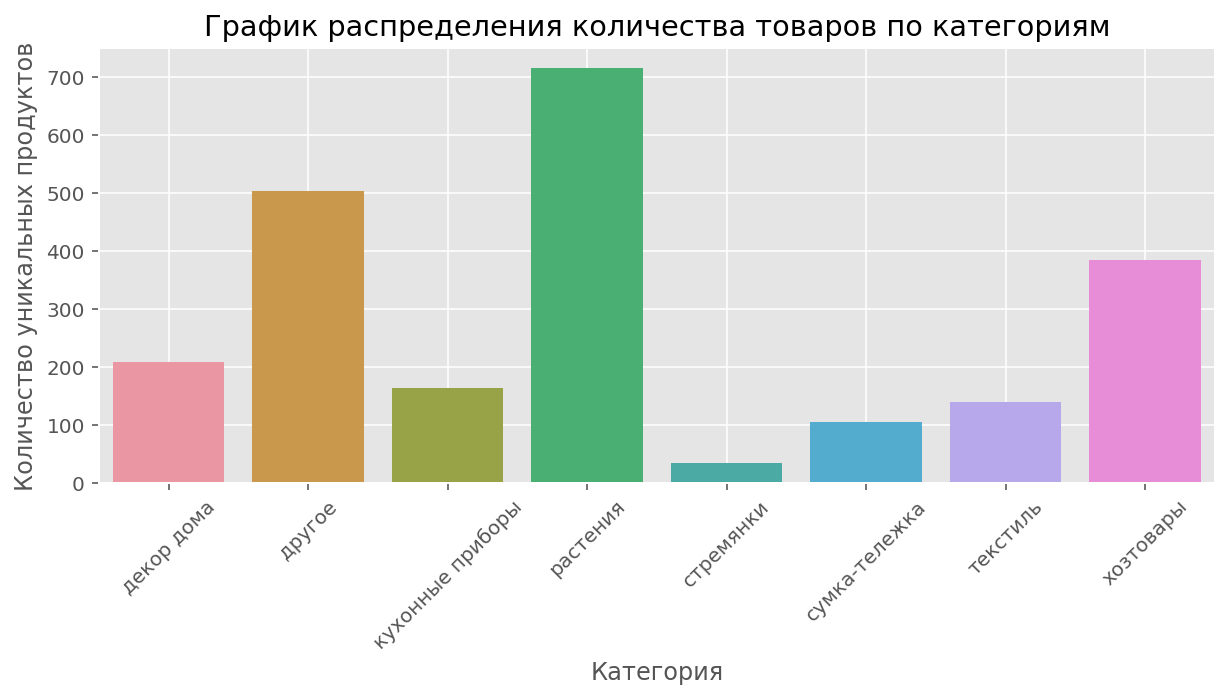

In [30]:
plt.figure(figsize=(10, 4))

sn.barplot(data=category, x='category', y='product')
plt.xticks(rotation=45)
plt.title('График распределения количества товаров по категориям')
plt.xlabel('Категория')
plt.ylabel('Количество уникальных продуктов')
plt.grid(True)

plt.show()

Больше всего получилось в категории растений (714 товаров) и меньше всего в категории стремянки (34).

Проанализируем количество проданных товаров каждой категории.

In [31]:
#Категоризация основного датасета
df['category'] = 'другое'
df.loc[df.query('word == @plants').index, 'category'] = 'растения'
df.loc[df.query('word == @ladder').index, 'category'] = 'стремянки'
df.loc[df.query('word == @households').index, 'category'] = 'хозтовары'
df.loc[df.query('word == @trolley_bag').index, 'category'] = 'сумка-тележка'
df.loc[df.query('word == @home_decor').index, 'category'] = 'для дома'
df.loc[df.query('word == @textile').index, 'category'] = 'текстиль'
df.loc[df.query('word == @kitchenware').index, 'category'] = 'кухня'
df.head()


date                           customer_id  order_id  \
0 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   

                                              product  quantity  price  month  \
0     комнатное растение в горшке алое вера, d12, h30         1  142.0     10   
1  комнатное растение в горшке кофе арабика, d12, h25         1  194.0     10   
2                         радермахера d-12 см h-20 см         1  112.0     10   
3                    хризолидокарпус лутесценс d-9 см         1  179.0     10   
4                      циперус зумула d-12 см h-25 см         1  112.0     10   

   year  revenue             word  category  
0  2018    142.0        комнатное  растения  
1  2018    194.0        комнатное  растения  
2  2018    112.0      радермахера    другое  
3  2018    179.0  хризолидокарпус    другое  
4  2018    112.0          циперус  растения

In [32]:
print(f'Уникальных пользователей  - {df["customer_id"].nunique()}')
print(f'Уникальных товаров - {df["product"].nunique()}')
print(f'Уникальных заказов - {df["order_id"].nunique()}')



Уникальных пользователей  - 2362
Уникальных товаров - 2250
Уникальных заказов - 3275


In [33]:
#Построим графики динамики выручки категорий 
dynamics = df.groupby(['category', 'month']).agg({'revenue':'sum'}).reset_index()

fig = px.bar(
    dynamics,
    x='month',
    y='revenue',
    color='category',
    title='Динамика выручки по месяцам и категориям товаров',
)
fig.update_xaxes(tickangle=45)
fig.show() 

Большую часть выручки приносят категории "хозтовары" и "сумка-тележка".
В апрелe,  мае и частично в марте заметно увеличилась доля товаров категории "растения", в остальные месяцы данная категория менее доходна, вероятно, это связано с садово-огородным периодом.


In [34]:
#посчитаем количество заказов по пользователям, сгруппировав по столбцу customer_id и применив агрегирующую функцию к order_id
orders_by_users = (
    df.groupby(by=['category','customer_id'], as_index=False).agg({'order_id': 'nunique','revenue':'sum'}))
#переименуем столбцы
orders_by_users.columns = ['category','customer_id','orders','revenue']
orders_by_users['avg_revenue'] = orders_by_users['revenue']/orders_by_users['orders']
#выведем первые 5 строк
display(orders_by_users.sort_values(by='avg_revenue', ascending=False).head()) 

category                           customer_id  orders  revenue  \
30         для дома  1b2764ad-9151-4051-a46a-9b01b62e6335       1  24370.0   
2845      хозтовары  909564b8-3a5c-4d3e-8310-5ba1c837bbd7       1  16536.0   
2263  сумка-тележка  f279d50f-a508-40b4-bde5-5cb4a1be3ad0       1  15358.0   
2514      хозтовары  0d87f4ae-465a-4fac-81e6-5d629761783e       1  14917.0   
2877      хозтовары  9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f       1  13448.0   

      avg_revenue  
30        24370.0  
2845      16536.0  
2263      15358.0  
2514      14917.0  
2877      13448.0

In [35]:
df.describe().T


count          mean           std      min      25%      50%  \
order_id  5273.0  55283.438650  33121.564514  12624.0  14791.0  69178.0   
quantity  5273.0      1.683103      2.443654      1.0      1.0      1.0   
price     5273.0    523.149456    973.319953      9.0     90.0    150.0   
month     5273.0      6.590176      3.574626      1.0      4.0      6.0   
year      5273.0   2018.852266      0.477473   2018.0   2019.0   2019.0   
revenue   5273.0    631.061524   1160.682816      9.0    119.0    188.0   

              75%       max  
order_id  72044.0  112789.0  
quantity      1.0      25.0  
price       488.0   14917.0  
month        10.0      12.0  
year       2019.0    2020.0  
revenue     674.0   24370.0

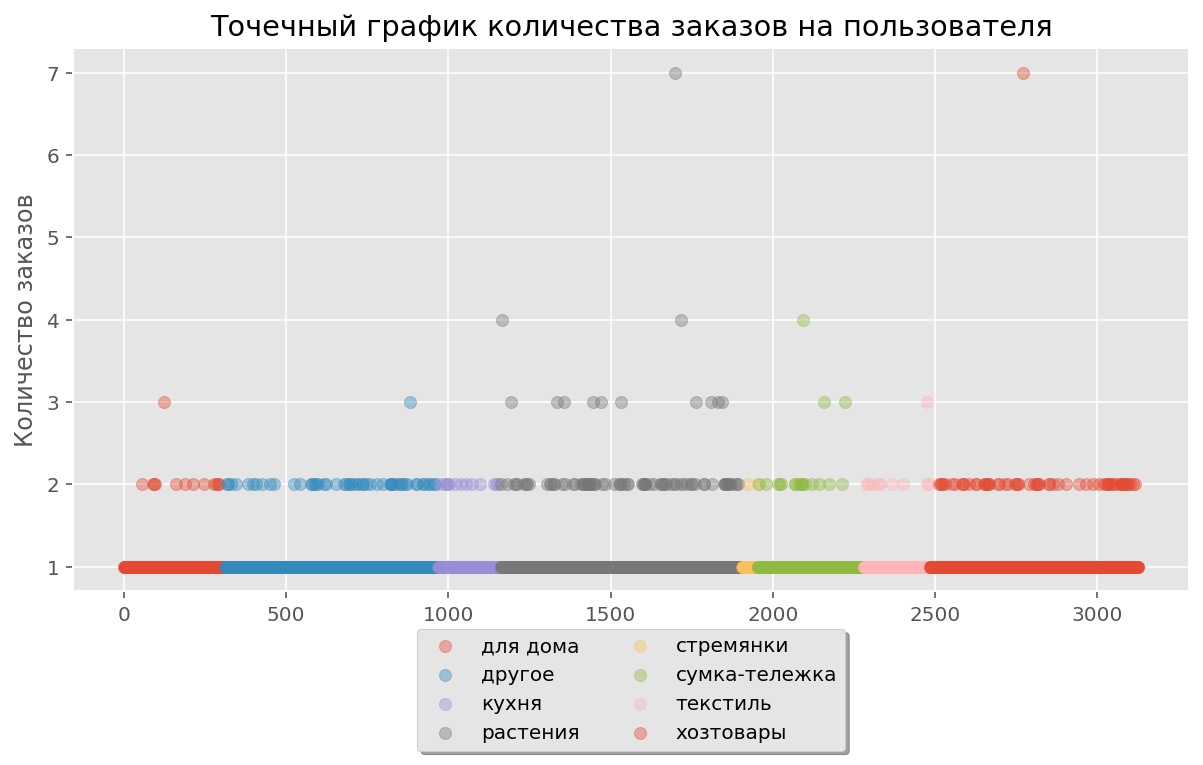

In [36]:
#построим точечную диаграмму заказов на пользователя
fig, ax = plt.subplots(figsize=(10,5))
ax.set(title='Точечный график количества заказов на пользователя', xlabel='Порядковый номер пользователя', ylabel='Количество заказов')
for cat in orders_by_users['category'].unique():
    data_filtered = orders_by_users.query('category == @cat')
    ax.scatter(data_filtered.index, data_filtered['orders'], alpha = 0.4, label=cat)
#ax.legend(bbox_to_anchor=(1, 1))
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=2)
#ax.grid()
plt.show()

В основном в каждой категории пользователи совершают 1 заказ (медиана и третий квартиль равны 1), есть пользователи с 2 заказами, но 3 и более встречаются крайне редко.

Построим точечный график заказов на пользователя


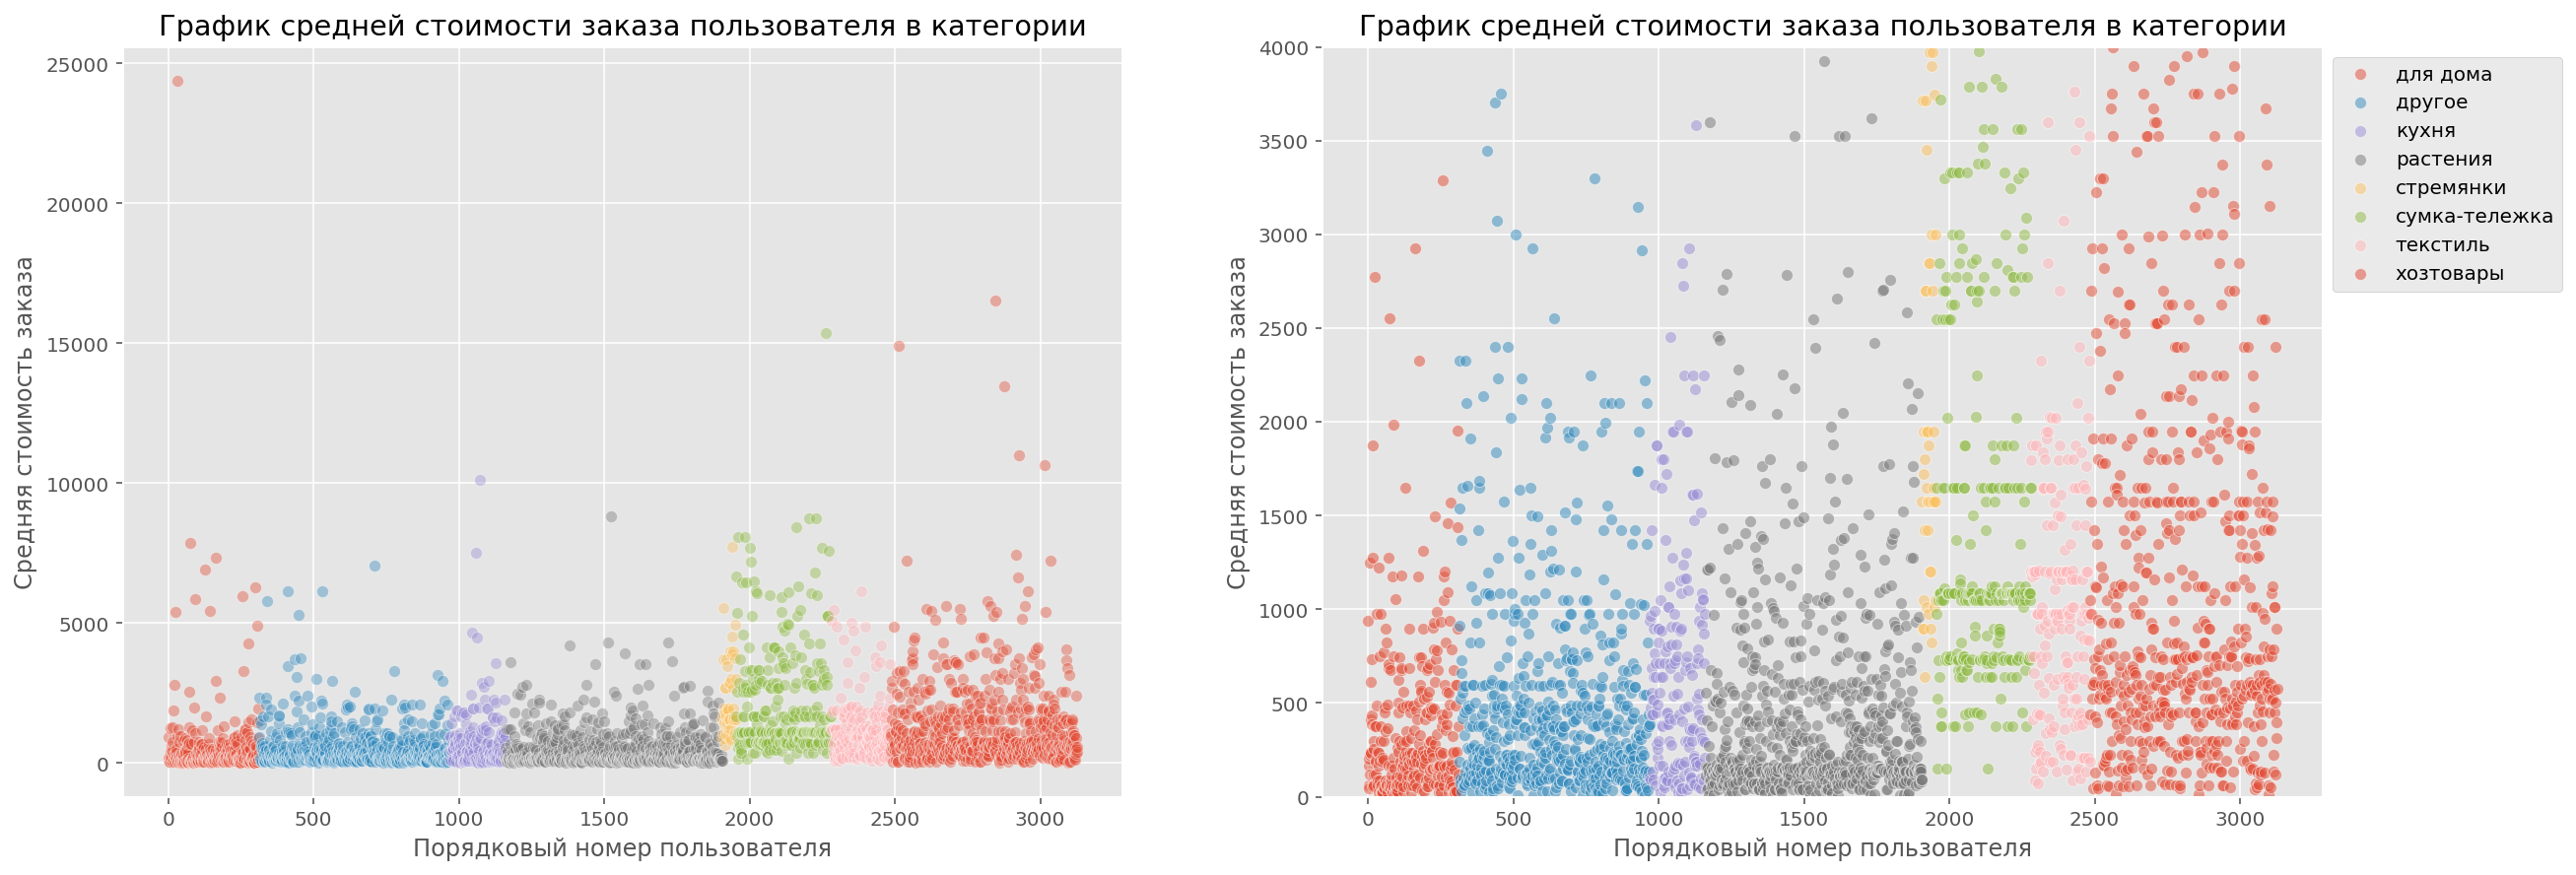

In [37]:
figure, ax = plt.subplots(1,2,figsize=(20,7))
for cat in orders_by_users['category'].unique():
    data_filtered = orders_by_users.query('category == @cat')
    ax[0].set(title='График средней стоимости заказа пользователя в категории', xlabel='Порядковый номер пользователя', ylabel='Средняя стоимость заказа')
    sn.scatterplot(data_filtered.index, data_filtered['avg_revenue'], alpha = 0.4,ax=ax[0])
    ax[1].set(title='График средней стоимости заказа пользователя в категории', xlabel='Порядковый номер пользователя', ylabel='Средняя стоимость заказа')
    sn.scatterplot(data_filtered.index, data_filtered['avg_revenue'], alpha = 0.5, label=cat, ax=ax[1])
    plt.ylim(0,4000)
    plt.legend(bbox_to_anchor=(1, 1))
plt.show()


Tовары для дома имеют наибольшее количество "выбросов" - пользователи с высоким средним чеком. Крупные заказы присутсвуют и в категории "текстиль" и "сумка- тележка".

### Динамика  заказов во времени

In [38]:
#выделим месяц
df['month'] = df['date'].astype('datetime64[M]')
df.month.unique()

array(['2018-10-01T00:00:00.000000000', '2018-11-01T00:00:00.000000000',
       '2018-12-01T00:00:00.000000000', '2019-01-01T00:00:00.000000000',
       '2019-02-01T00:00:00.000000000', '2019-03-01T00:00:00.000000000',
       '2019-04-01T00:00:00.000000000', '2019-05-01T00:00:00.000000000',
       '2019-06-01T00:00:00.000000000', '2019-07-01T00:00:00.000000000',
       '2019-08-01T00:00:00.000000000', '2019-09-01T00:00:00.000000000',
       '2019-10-01T00:00:00.000000000', '2019-11-01T00:00:00.000000000',
       '2019-12-01T00:00:00.000000000', '2020-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [39]:
revenue_by_month = df.groupby(by=['month','category'],as_index=False).agg({'order_id':'nunique','customer_id':'nunique','revenue':'sum'})
#переименуем столбцы
revenue_by_month.columns = ['month','category','orders','customers','revenue']
revenue_by_month

month       category  orders  customers       revenue
0   2018-10-01       для дома      21         21  16559.000000
1   2018-10-01         другое      51         51  34617.000000
2   2018-10-01          кухня      12         11  13828.000000
3   2018-10-01       растения      35         33  24348.000000
4   2018-10-01      стремянки       6          6  12444.000000
..         ...            ...     ...        ...           ...
123 2020-01-01       растения      88         88  13564.166667
124 2020-01-01      стремянки       2          2   4761.000000
125 2020-01-01  сумка-тележка       9          9  28290.000000
126 2020-01-01       текстиль      14         14  12620.000000
127 2020-01-01      хозтовары      45         45  68629.000000

[128 rows x 5 columns]

In [40]:
#создаем датафрейм dates_groups с уникальными парами значений 'date' и 'category' таблицы revenue_by_month
dates_groups = revenue_by_month[['month', 'category']].drop_duplicates()

In [41]:
#соберём агрегированные кумулятивные по месяцам
orders_aggregated = dates_groups.apply(
    lambda x: revenue_by_month[
        np.logical_and(
            revenue_by_month['month'] <= x['month'], revenue_by_month['category'] == x['category']
        )
    ].agg(
        {
            'month': 'max',
            'category': 'max',
            'orders': 'sum',
            'customers': 'sum',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['month', 'category'])
orders_aggregated


month       category  orders  customers        revenue
0   2018-10-01       для дома      21         21   16559.000000
1   2018-10-01         другое      51         51   34617.000000
2   2018-10-01          кухня      12         11   13828.000000
3   2018-10-01       растения      35         33   24348.000000
4   2018-10-01      стремянки       6          6   12444.000000
..         ...            ...     ...        ...            ...
123 2020-01-01       растения     853        805  433657.333333
124 2020-01-01      стремянки      50         49  117439.000000
125 2020-01-01  сумка-тележка     351        336  740448.250000
126 2020-01-01       текстиль     215        209  262559.500000
127 2020-01-01      хозтовары     710        683  974584.000000

[128 rows x 5 columns]

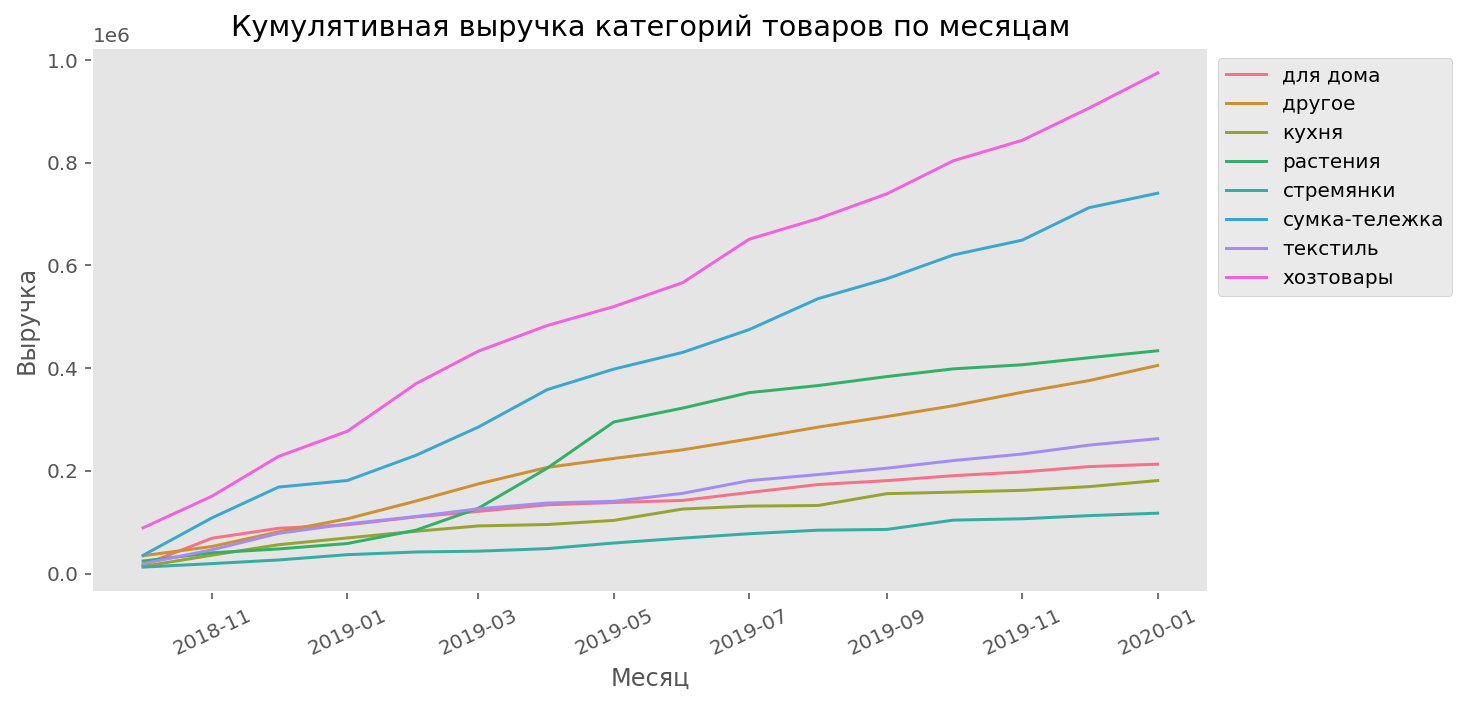

In [42]:
#строим графики
plt.figure(figsize=(10,5))
sn.lineplot(data=orders_aggregated,x='month', y='revenue', hue='category')
plt.legend()
plt.title('Кумулятивная выручка категорий товаров по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.xticks(rotation = 25)
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()


Как уже было видно ранее, наибольшее количество выручки принесли для магазина "хозтовары" - 1 млн.y.e и "сумка- тележка" - по 700 000 y.e. и растения - 380 000 y.e  за весь рассматриваемый период.

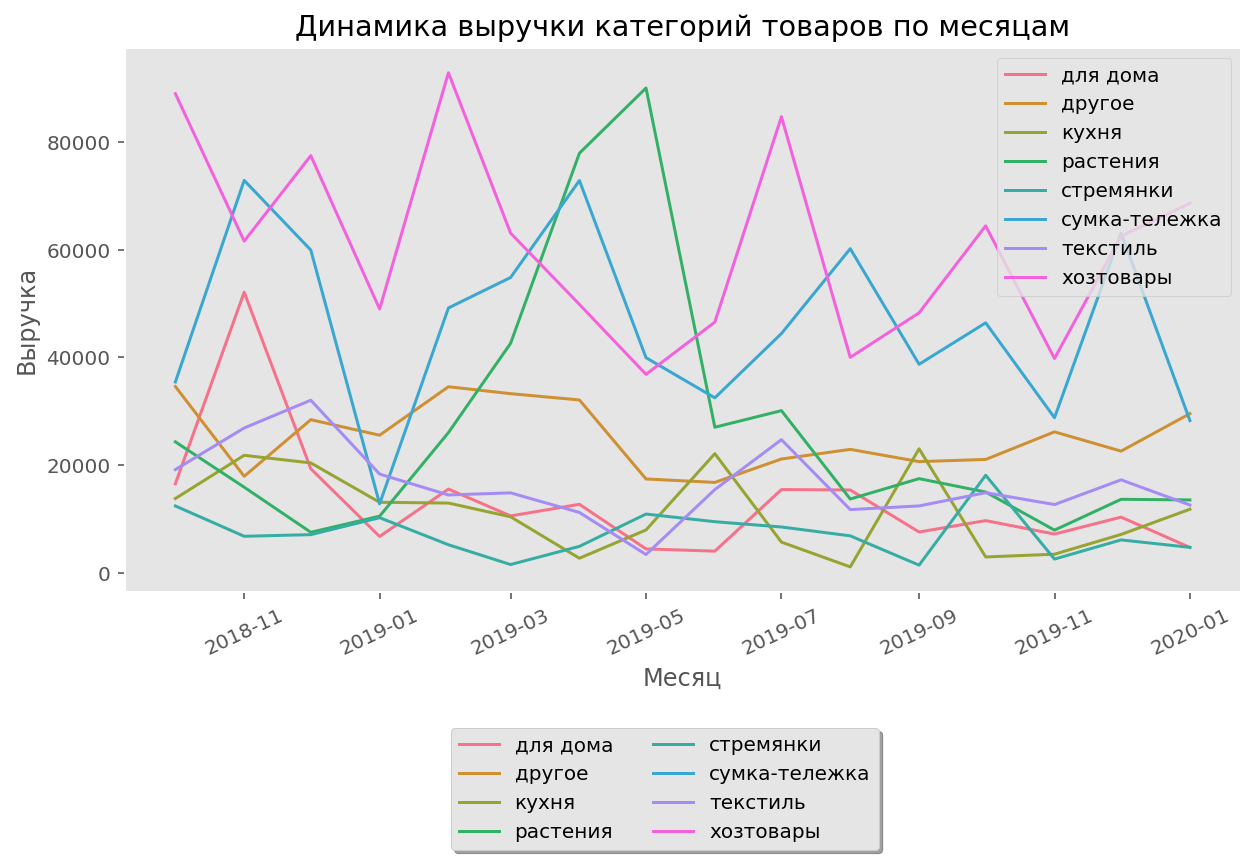

In [43]:
#строим графики
ax = plt.figure(figsize=(10,5))
sn.lineplot(data=revenue_by_month, x='month', y='revenue', hue='category')
plt.legend()
plt.title('Динамика выручки категорий товаров по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.xticks(rotation = 25)
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=2)
#plt.legend(bbox_to_anchor=(1, 1))
plt.grid()

По графику можно сделать вывод, что товары категории растения приносят наибольшее количество выручки  с марта по июнь, как раз когда начинается дачный сезон. Товары для кухни и дома пользуются больше популряностью в зимнее время года. 
Заметен общий тренд на снижение суммарной выручки магазина.

In [44]:
total_revenue_by_month = df.groupby(by='month',as_index=False).agg({'order_id':'nunique','customer_id':'nunique','revenue':'sum'})
#переименуем столбцы
total_revenue_by_month.columns = ['month','orders','customers','revenue']
total_revenue_by_month

month  orders  customers        revenue
0  2018-10-01     178        173  245403.000000
1  2018-11-01     180        173  276035.000000
2  2018-12-01     228        220  252383.000000
3  2019-01-01     153        143  146486.000000
4  2019-02-01     255        240  250970.000000
5  2019-03-01     227        219  231322.000000
6  2019-04-01     257        231  264403.000000
7  2019-05-01     172        158  211144.000000
8  2019-06-01     154        145  174164.000000
9  2019-07-01     198        186  234932.000000
10 2019-08-01     172        164  172100.000000
11 2019-09-01     177        169  169791.000000
12 2019-10-01     195        166  192741.000000
13 2019-11-01     217        217  128791.750000
14 2019-12-01     246        246  202885.333333
15 2020-01-01     269        269  174036.333333

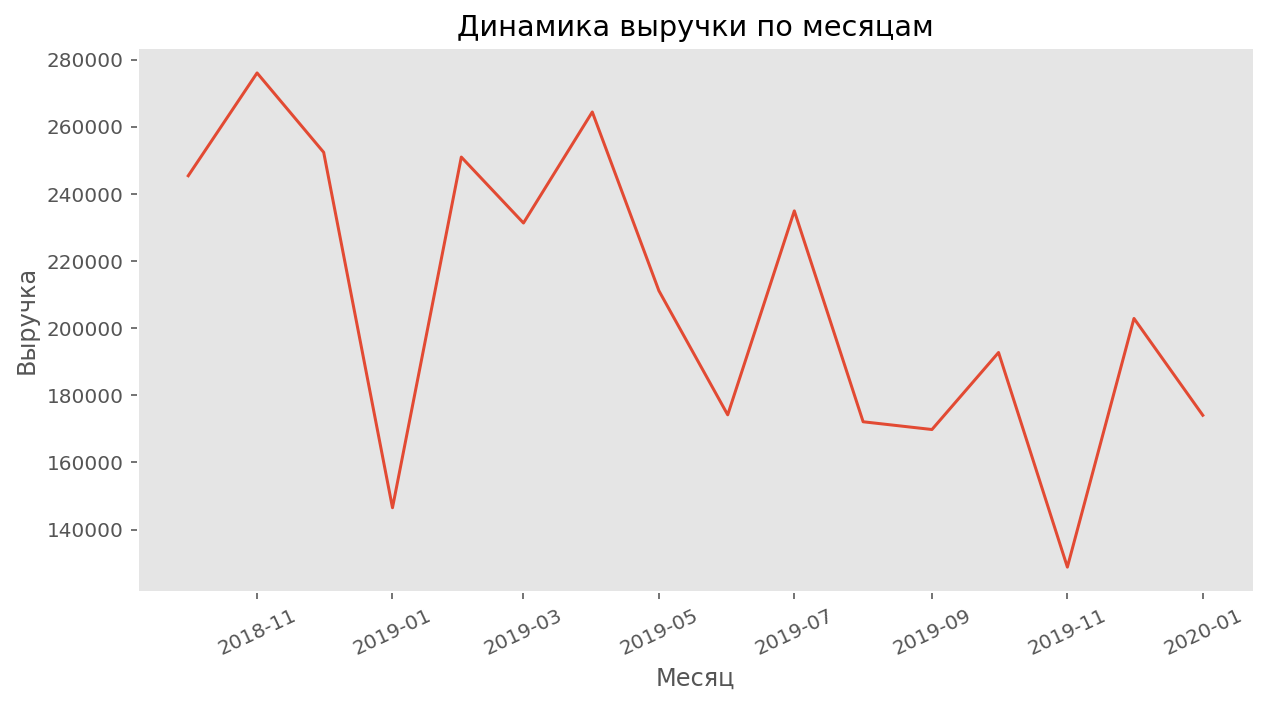

In [45]:
#строим графики
plt.figure(figsize=(10,5))
sn.lineplot(data=total_revenue_by_month, x='month', y='revenue')
plt.title('Динамика выручки по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.xticks(rotation = 25)
plt.grid()


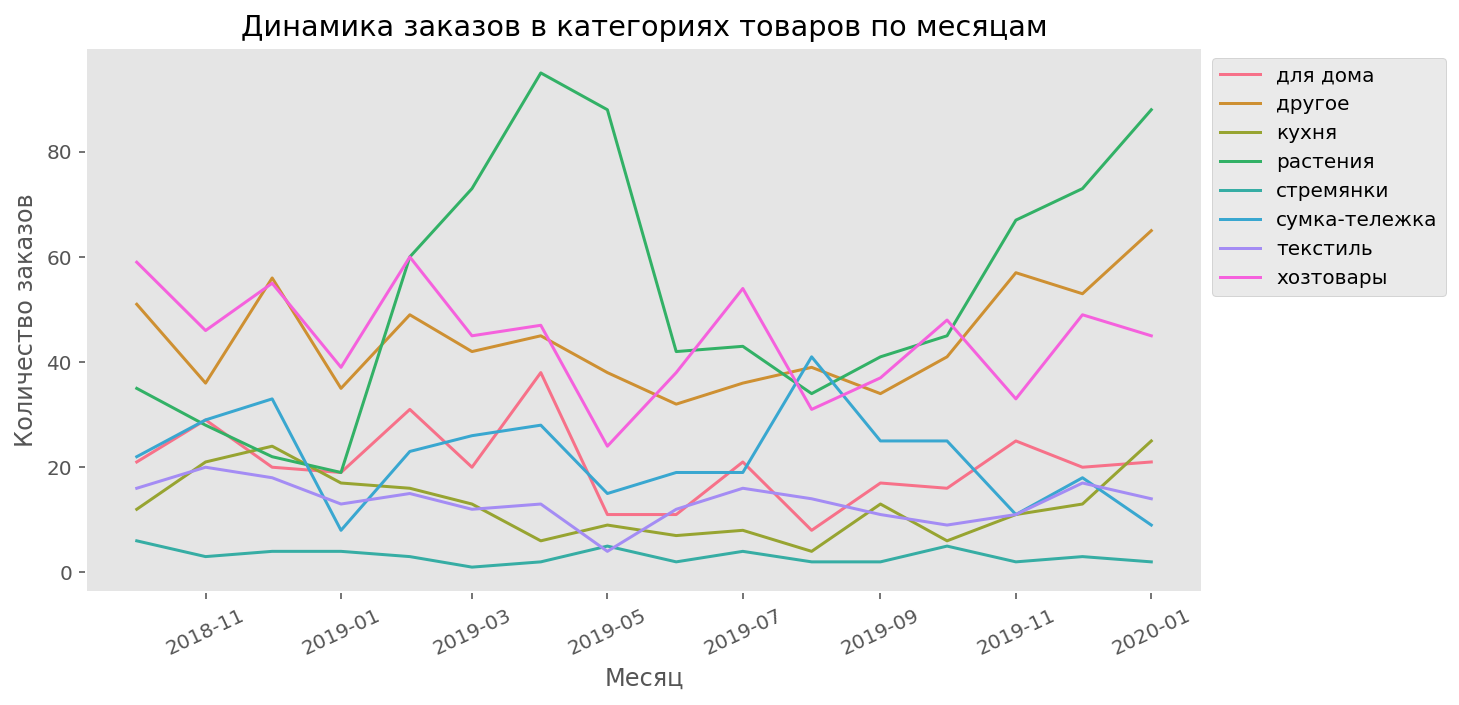

In [46]:
#строим графики
plt.figure(figsize=(10,5))
sn.lineplot(data=revenue_by_month,x='month', y='orders', hue='category')
plt.legend()
plt.title('Динамика заказов в категориях товаров по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.xticks(rotation = 25)
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()

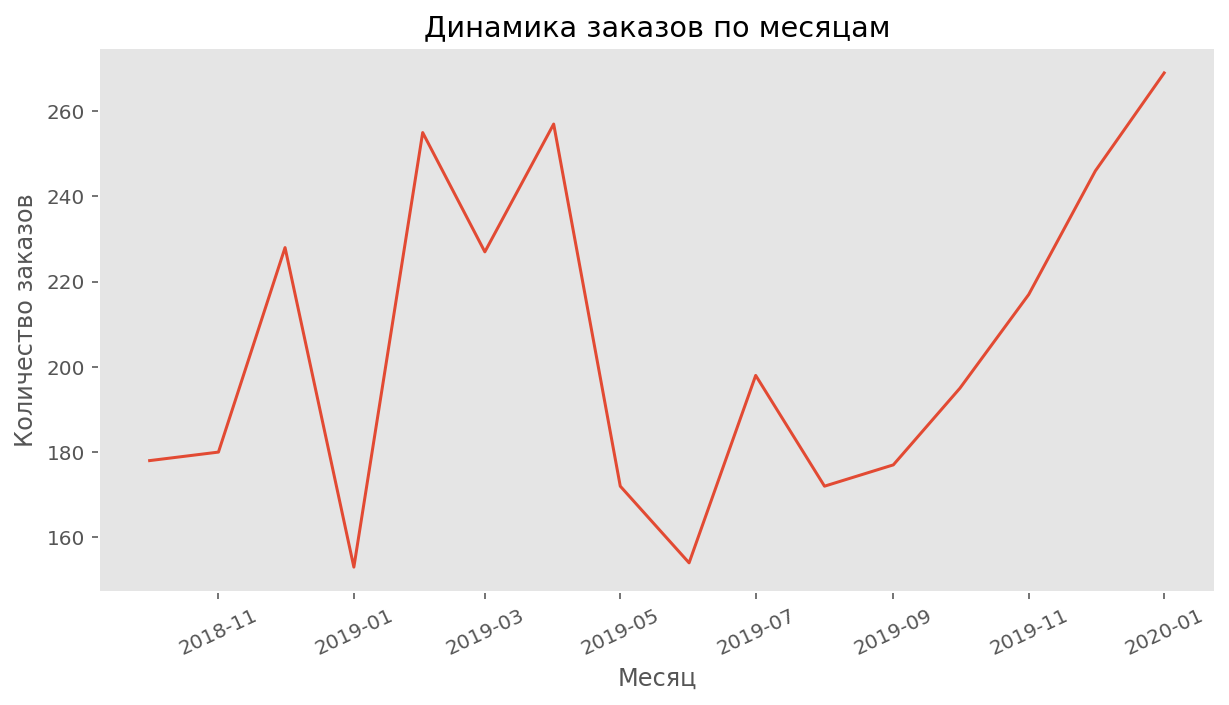

In [47]:
#строим графики
plt.figure(figsize=(10,5))
sn.lineplot(data=total_revenue_by_month,x='month', y='orders')
#plt.legend()
plt.title('Динамика заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.xticks(rotation = 25)
#plt.legend(bbox_to_anchor=(1, 1))
plt.grid()

Опять же заметно, что пик количества заказов в категории "растения" приходится c марта по июнь. В среднем количество заказов в категории "товары для кухни" выше в в зимнии период. По остальным категориям количество заказов постоянно находится примерно в одном диапазоне.
Максимальное количество заказов наблюдается в период с февраля по апрель 2019 (примерно 250 заказов каждый месяц).

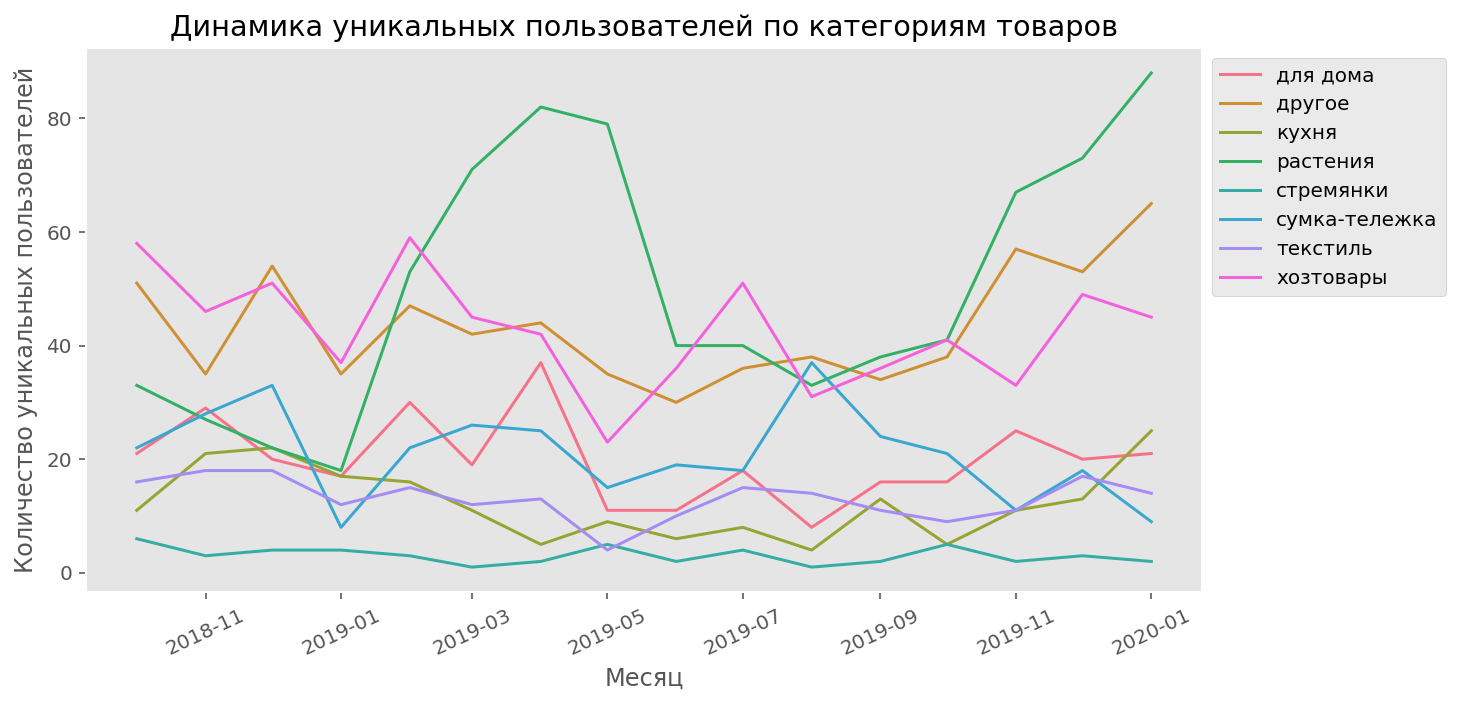

In [48]:
#строим графики
plt.figure(figsize=(10,5))
sn.lineplot(data=revenue_by_month,x='month', y='customers', hue='category')
plt.legend()
plt.title('Динамика уникальных пользователей по категориям товаров')
plt.xlabel('Месяц')
plt.ylabel('Количество уникальных пользователей')
plt.xticks(rotation = 25)
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()

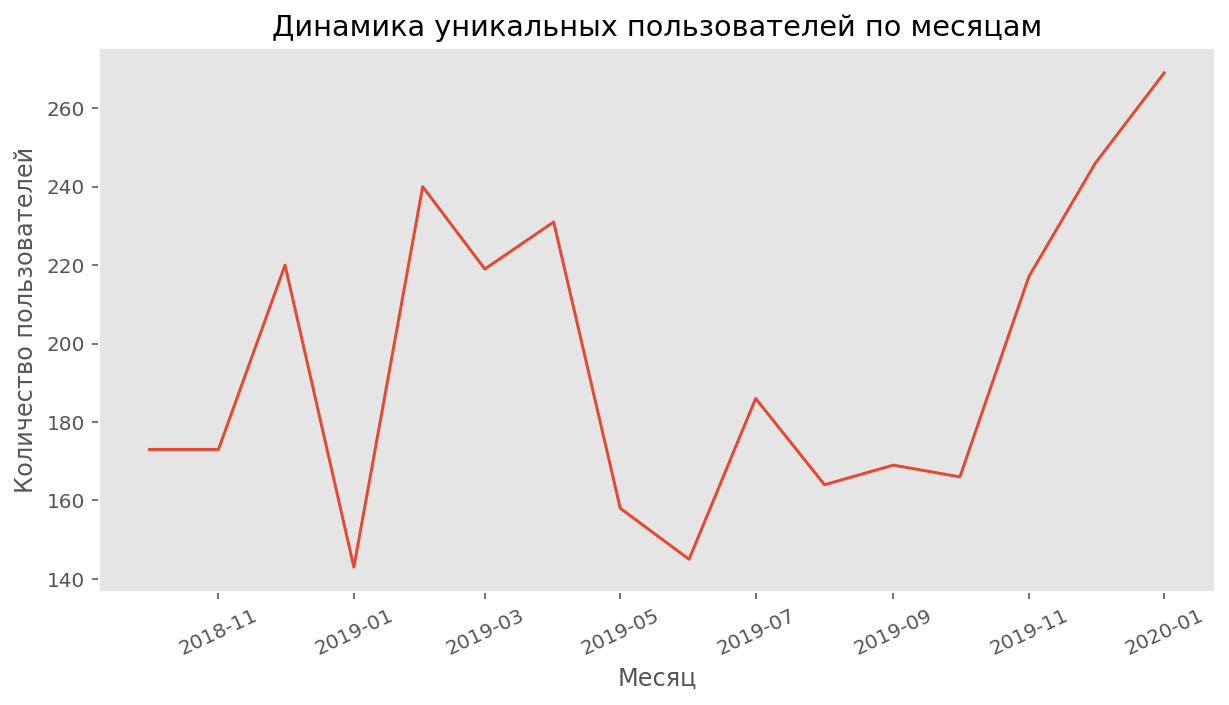

In [49]:
#строим графики
plt.figure(figsize=(10,5))
sn.lineplot(data=total_revenue_by_month,x='month', y='customers')
#plt.legend()
plt.title('Динамика уникальных пользователей по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество пользователей')
plt.xticks(rotation = 25)
#plt.legend(bbox_to_anchor=(1, 1))
plt.grid()


Динамика уникальных пользователей по месяцам также подтверждает сказанные выше предположения о сезонности товаров.
Пик количества уникальных пользователей, как и пик количества заказов, приходится на февраль-июнь 2019. 

In [50]:
#посчитаем средний чек пользователя в каждой категории товаров
data_by_users = df.groupby(by=['category','customer_id','month'],as_index=False).agg({'order_id':'nunique','revenue':'sum'})
#переименуем столбцы
data_by_users.columns = ['category','customer_id','month','orders','revenue']
data_by_users['avg_revenue'] = data_by_users['revenue']/data_by_users['orders']
data_by_users.head()

category                           customer_id      month  orders  revenue  \
0  для дома  00bd74b1-2792-47db-a2f1-680a09ac5026 2018-10-01       1    937.0   
1  для дома  02cb74c5-348f-43dc-ba4d-e546a21a07f1 2019-12-01       1    164.0   
2  для дома  03b7b4a5-9e2c-42f9-a131-96f3d2772f17 2019-11-01       1    202.0   
3  для дома  055119fa-4ffb-4780-a696-3cf6808daadf 2019-11-01       1     59.0   
4  для дома  0655a313-acda-44ee-87dc-5477b47742e6 2019-02-01       1     44.0   

   avg_revenue  
0        937.0  
1        164.0  
2        202.0  
3         59.0  
4         44.0

In [51]:
#средний чек по всем пользователям в каждой категории товаров
avg_revenue_by_month = data_by_users.groupby(by=['category','month'],as_index=False).agg({'avg_revenue':'mean'})
avg_revenue_by_month

category      month  avg_revenue
0     для дома 2018-10-01   788.523810
1     для дома 2018-11-01  1797.068966
2     для дома 2018-12-01   967.450000
3     для дома 2019-01-01   376.941176
4     для дома 2019-02-01   514.666667
..         ...        ...          ...
123  хозтовары 2019-09-01  1290.111111
124  хозтовары 2019-10-01  1429.114983
125  хозтовары 2019-11-01  1206.318182
126  хозтовары 2019-12-01  1275.908163
127  хозтовары 2020-01-01  1525.088889

[128 rows x 3 columns]

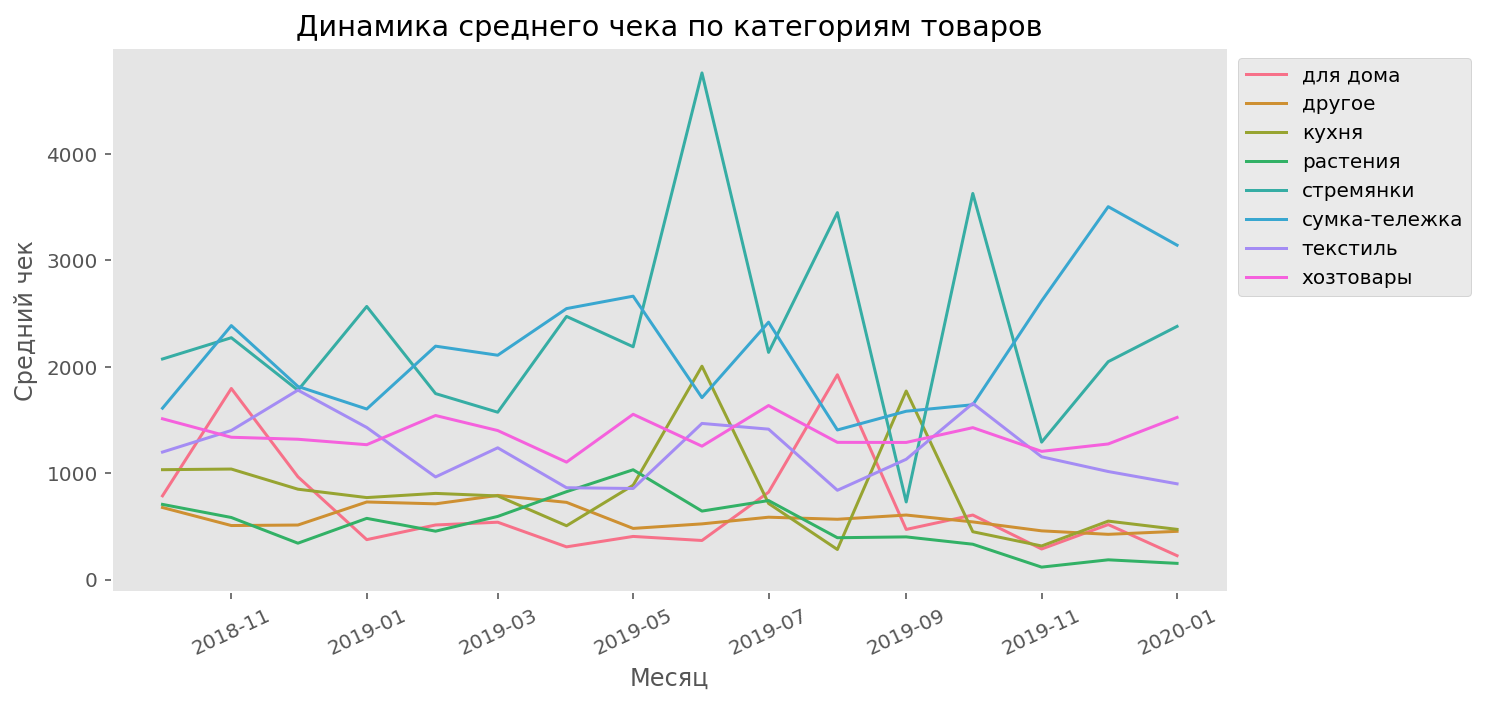

In [52]:
#строим графики
plt.figure(figsize=(10,5))
sn.lineplot(data=avg_revenue_by_month,x='month', y='avg_revenue', hue='category')
plt.legend()
plt.title('Динамика среднего чека по категориям товаров')
plt.xlabel('Месяц')
plt.ylabel('Средний чек')
plt.xticks(rotation = 25)
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()


In [53]:
#средний чек по всем пользователям 
all_users_by_month = data_by_users.groupby(by='month',as_index=False).agg({'avg_revenue':'mean'})
all_users_by_month

month  avg_revenue
0  2018-10-01  1104.339450
1  2018-11-01  1295.176329
2  2018-12-01  1070.770089
3  2019-01-01   964.317568
4  2019-02-01  1000.887755
5  2019-03-01  1008.162996
6  2019-04-01   960.497333
7  2019-05-01  1111.022099
8  2019-06-01  1036.084416
9  2019-07-01  1201.452632
10 2019-08-01   954.725904
11 2019-09-01   948.022989
12 2019-10-01   980.146104
13 2019-11-01   593.510369
14 2019-12-01   824.737127
15 2020-01-01   646.975217

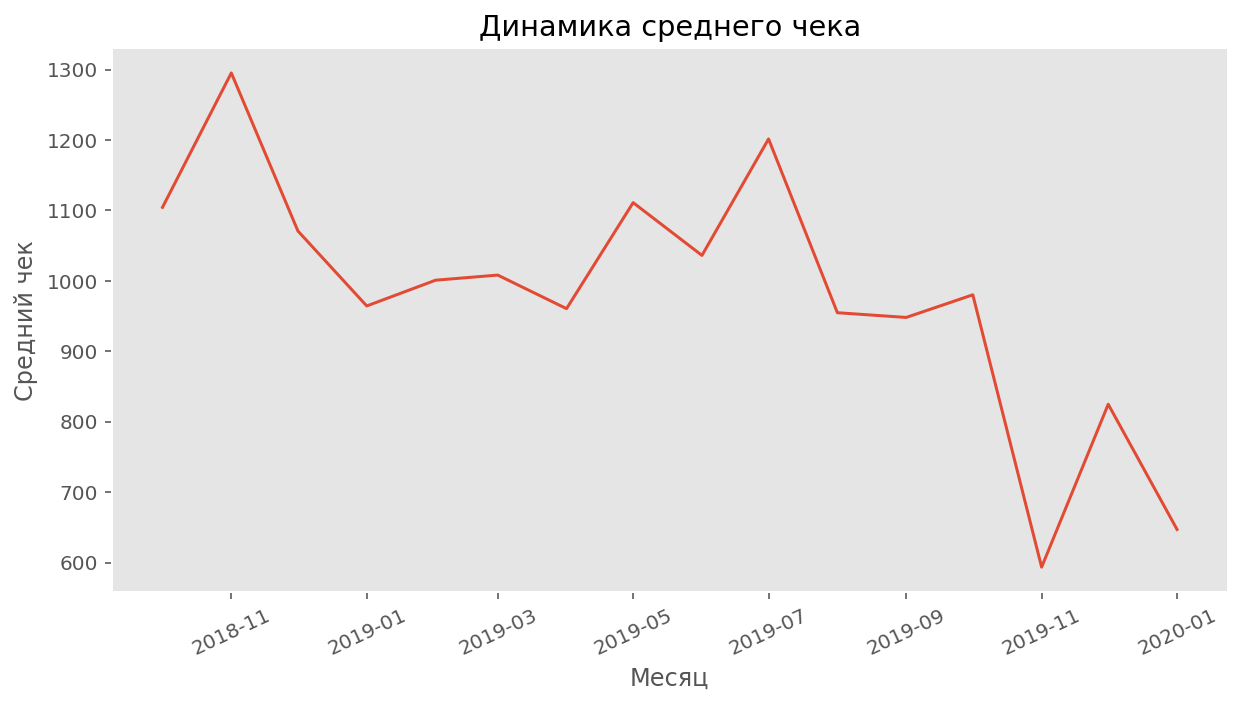

In [54]:
#строим графики
plt.figure(figsize=(10,5))
sn.lineplot(data=all_users_by_month,x='month', y='avg_revenue')
plt.title('Динамика среднего чека')
plt.xlabel('Месяц')
plt.ylabel('Средний чек')
plt.xticks(rotation = 25)
plt.grid()


In [55]:
#проверим пики для категории стремянки
df.query('customer_id=="e3687048-7d49-4e68-bb2c-4b7a3acbec63" and category=="стремянки"')

date                           customer_id  order_id  \
3806 2019-06-17 09:00:00  e3687048-7d49-4e68-bb2c-4b7a3acbec63     71724   

                                                       product  quantity  \
3806  стремянки colombo leonardo 3 ступени g300a03w черая 3649         1   

       price      month  year  revenue       word   category  
3806  3974.0 2019-06-01  2019   3974.0  стремянки  стремянки

In [56]:
#проверим пики товаров для категории стремянки
df.query('customer_id=="540072bd-cc85-43b5-a6d6-0a8720499e65" and category=="стремянки"')

date                           customer_id  order_id  \
4322 2019-08-18 10:00:00  540072bd-cc85-43b5-a6d6-0a8720499e65     72329   
4323 2019-08-18 10:00:00  540072bd-cc85-43b5-a6d6-0a8720499e65     72330   

                                                     product  quantity  \
4322  стремянка colombo factotum 4 ступени алюминий g110at4w         1   
4323  стремянка colombo factotum 4 ступени алюминий g110at4w         1   

       price      month  year  revenue       word   category  
4322  3449.0 2019-08-01  2019   3449.0  стремянка  стремянки  
4323  3449.0 2019-08-01  2019   3449.0  стремянка  стремянки

Наибольший средний чек имеют следующие категории товаров: стремянки, сумка- тележка и товары для кухни. Заметны большие пики для категории стремянки в июне и августе, что обусловлено крупными покупками (стремянки COLOMBO 2мя пользователями), поэтому нельзя утержать, что средний чек для этой категории будет самым высоким. Товары для кухни и текстиль также имеют пики (но не такие ярковыраженные), возможно, также из-за крупных заказов отдельных пользователей.

### Recency, Monetary and Frequency анализ

In [57]:
#транзакции совершались в период
print('Продажи с {} по {}'.format(df['date'].min(),
                                    df['date'].max()))

Продажи с 2018-10-01 00:00:00 по 2020-01-31 15:00:00


Примем за момент анализа максимальную дату продаж + 1 день


In [58]:
NOW = df['date'].max() + timedelta(days=1)
NOW

Timestamp('2020-02-01 15:00:00')

In [59]:
#добавим столбец, 'days_since_last_purchase', с количеством дней между покупкой и  принятым моментом анализа - Recently
df['days_since_purchase'] = df['date'].apply(lambda x:(NOW - x).days)
df

date                           customer_id  order_id  \
0    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
...                  ...                                   ...       ...   
5585 2020-01-30 21:00:00  63208953-a8e4-4f77-9b47-3a46e7b72eee    104002   
5586 2020-01-30 22:00:00  d99d25f1-4017-4fcd-8d29-c580cc695a1a    107336   
5587 2020-01-31 02:00:00  2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6    106336   
5588 2020-01-31 12:00:00  cdd17932-623e-415f-a577-3b31312fd0e2    102002   
5589 2020-01-31 15:00:00  2e460a26-35af-453d-a369-a036e95a40e0    103225   

                                                                                  product  \
0                                         комнатное растение в горшке алое вера, d12, h30   
1                                      комнатное растение в горшке кофе арабика, d12, h25   
2                                                             радермахера d-12 см h-20 см   
3                                                        хризолидокарпус лутесценс d-9 см   
4                                                          циперус зумула d-12 см h-25 см   
...                                                                                   ...   
5585  томата (помидор) черниченский черри № 116 сорт индетерминантный позднеспелый черный   
5586                                           дендробиум санок анна грин 1 ствол d-12 см   
5587                              подставка для обуви резиновая attribute 80x40 см amc080   
5588                  тагетис крупноцветковый рассада однолетних цветов в кассете по 6 шт   
5589                                    вешалка для блузок 41 см красный attribute ahm781   

      quantity  price      month  year  revenue             word   category  \
0            1  142.0 2018-10-01  2018    142.0        комнатное   растения   
1            1  194.0 2018-10-01  2018    194.0        комнатное   растения   
2            1  112.0 2018-10-01  2018    112.0      радермахера     другое   
3            1  179.0 2018-10-01  2018    179.0  хризолидокарпус     другое   
4            1  112.0 2018-10-01  2018    112.0          циперус   растения   
...        ...    ...        ...   ...      ...              ...        ...   
5585         2   38.0 2020-01-01  2020     76.0           томата   растения   
5586         1  869.0 2020-01-01  2020    869.0       дендробиум     другое   
5587         1  354.0 2020-01-01  2020    354.0        подставка     другое   
5588         1  128.0 2020-01-01  2020    128.0          тагетис     другое   
5589         1  104.0 2020-01-01  2020    104.0          вешалка  хозтовары   

      days_since_purchase  
0                     488  
1                     488  
2                     488  
3                     488  
4                     488  
...                   ...  
5585                    1  
5586                    1  
5587                    1  
5588                    1  
5589                    1  

[5273 rows x 12 columns]

Посмотрим на лояльных покупателей. 
Recency будет минимальное количество 'days_since_last_purchase' для каждого покупателя . Frequency полное количество уникальных заказов для  покупателя . Monetary общая сумма покупок клиента за все время

In [60]:
aggr = {
    'days_since_purchase': lambda x:x.min(),
    'order_id': lambda x: x.nunique(),
    'revenue' : lambda x: x.sum()
        }
aggr

{'days_since_purchase': <function __main__.<lambda>(x)>,
 'order_id': <function __main__.<lambda>(x)>,
 'revenue': <function __main__.<lambda>(x)>}

In [61]:
#подготовим данные для rfm анализа
rfm = df.groupby('customer_id').agg(aggr).reset_index()
rfm.rename(columns={'days_since_purchase': 'recency',
                   'order_id': 'frequency',
                   'revenue':'monetary'},
          inplace=True)

In [62]:
rfm.sort_values('monetary', ascending=False)


customer_id  recency  frequency  monetary
257   1b2764ad-9151-4051-a46a-9b01b62e6335      452          1   24370.0
1448  9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f      463          1   22056.0
1052  73d1cd35-5e5f-4629-8cf2-3fda829d4e58       93         17   21361.0
1339  940c175f-ea87-44e0-9e16-0a3d0a9abecd      234          2   20232.0
2231  f279d50f-a508-40b4-bde5-5cb4a1be3ad0       32          2   16557.0
...                                    ...      ...        ...       ...
390   2b6439c9-1ae1-4785-9509-ca4348b3d39a      278          1      22.0
2138  e9e94e71-4cd2-47fc-9b3f-1ec96bd2d95e      284          1      22.0
306   21df03ad-d9ac-47e9-a482-5372fd3e2464      304          1      22.0
318   2330d859-e9cb-4c8f-abd0-55f9e27e6745      445          1      15.0
1374  9777b839-4212-41bb-94c2-87de3658248a        3          1      15.0

[2362 rows x 4 columns]

*Считаем R, F and M баллы*


Зададим  рейтинг от 1 до 3 в зависимости от recency, monetary and frequency 
Затем используем метод деления на квантили, в результате выборка будет поделена на 3 равные части.


In [63]:
quintiles = rfm[['recency', 'frequency', 'monetary']].quantile([.33, .66, .99]).to_dict()
quintiles

{'recency': {0.33: 102.0, 0.66: 295.26, 0.99: 484.0},
 'frequency': {0.33: 1.0, 0.66: 2.0, 0.99: 3.0},
 'monetary': {0.33: 507.13, 0.66: 1244.6799999999998, 0.99: 8220.939999999995}}

In [64]:
quintiles_2 = rfm[['frequency']].quantile([0.5]).to_dict()
quintiles_2

{'frequency': {0.5: 1.0}}

Зададим рейтинг от 1 до 3 (frequency от 1 до 2). 
Bысокие значения лучше для frequency and monetary, в то время как низкие значения лучше для recency


In [65]:
#функция для ранжирования recency
def r_score(x):
    if x <= quintiles['recency'][.33]:
        return 3
    elif x <= quintiles['recency'][.66]:
        return 2
    else:
        return 1

In [66]:
#функция для ранжирования monetary
def fm_score(x, c):
    if x <= quintiles[c][.33]:
        return 1
    elif x <= quintiles[c][.66]:
        return 2
    else:
        return 3

In [67]:
#функция для ранжирования frequency
def f_score(x, c):
    if x <= quintiles_2[c][.5]:
        return 1
    else:
        return 2

In [68]:
#проставляем R, F and M оценки для каждого покупателя
rfm['r'] = rfm['recency'].apply(lambda x: r_score(x))
rfm['f'] = rfm['frequency'].apply(lambda x: f_score(x, 'frequency'))
rfm['m'] = rfm['monetary'].apply(lambda x: fm_score(x, 'monetary'))

In [69]:
rfm.head()


customer_id  recency  frequency  monetary  r  f  m
0  000d6849-084e-4d9f-ac03-37174eaf60c4      108          1     555.0  2  1  2
1  001cee7f-0b29-4716-b202-0042213ab038      350          1     442.0  1  1  1
2  00299f34-5385-4d13-9aea-c80b81658e1b      109          1     914.0  2  1  2
3  002d4d3a-4a59-406b-86ec-c3314357e498      369          1    1649.0  1  1  3
4  003bbd39-0000-41ff-b7f9-2ddaec152037      124          1    2324.0  2  1  3

In [70]:
#комбинируем R, F and M, чтобы создать уникальную RFM оценку

rfm['rfm_score'] = rfm['r'].map(str) + rfm['f'].map(str) + rfm['m'].map(str)
rfm.head()

customer_id  recency  frequency  monetary  r  f  \
0  000d6849-084e-4d9f-ac03-37174eaf60c4      108          1     555.0  2  1   
1  001cee7f-0b29-4716-b202-0042213ab038      350          1     442.0  1  1   
2  00299f34-5385-4d13-9aea-c80b81658e1b      109          1     914.0  2  1   
3  002d4d3a-4a59-406b-86ec-c3314357e498      369          1    1649.0  1  1   
4  003bbd39-0000-41ff-b7f9-2ddaec152037      124          1    2324.0  2  1   

   m rfm_score  
0  2       212  
1  1       111  
2  2       212  
3  3       113  
4  3       213

In [71]:
rfm['fm'] = ((rfm['f'] + rfm['m'])/2).apply(lambda x: math.ceil(x))
rfm.head()


customer_id  recency  frequency  monetary  r  f  \
0  000d6849-084e-4d9f-ac03-37174eaf60c4      108          1     555.0  2  1   
1  001cee7f-0b29-4716-b202-0042213ab038      350          1     442.0  1  1   
2  00299f34-5385-4d13-9aea-c80b81658e1b      109          1     914.0  2  1   
3  002d4d3a-4a59-406b-86ec-c3314357e498      369          1    1649.0  1  1   
4  003bbd39-0000-41ff-b7f9-2ddaec152037      124          1    2324.0  2  1   

   m rfm_score  fm  
0  2       212   2  
1  1       111   1  
2  2       212   2  
3  3       113   2  
4  3       213   2

In [72]:
rfm['fm'].unique()


array([2, 1, 3])

In [73]:
# создали только 7 сегментов, основанные на двух оценках: 'r' and 'fm'

segment_map = {
    r'11': 'lost',
    r'13': 'can\'t lose',
    r'[1-2][2-3]': 'at risk',
    r'2[1-2]': 'non active',
    r'33': 'loyal customers',
    r'31': 'new customers',
    r'32': 'potentially loyal'
}

rfm['segment'] = rfm['r'].map(str) + rfm['fm'].map(str)
rfm['segment'] = rfm['segment'].replace(segment_map, regex=True)
rfm.head(10)

customer_id  recency  frequency  monetary  r  f  \
0  000d6849-084e-4d9f-ac03-37174eaf60c4      108          1     555.0  2  1   
1  001cee7f-0b29-4716-b202-0042213ab038      350          1     442.0  1  1   
2  00299f34-5385-4d13-9aea-c80b81658e1b      109          1     914.0  2  1   
3  002d4d3a-4a59-406b-86ec-c3314357e498      369          1    1649.0  1  1   
4  003bbd39-0000-41ff-b7f9-2ddaec152037      124          1    2324.0  2  1   
5  004d24e9-4a6c-4d0e-8727-8391dfd4b43a      370          1    1536.0  1  1   
6  005ba170-45e8-42de-93f7-192481ae2659       87          2    7857.0  3  2   
7  00bd74b1-2792-47db-a2f1-680a09ac5026      468          1     937.0  1  1   
8  00c0f92a-121a-4883-a78d-2c7b5fe187de       51          2     321.0  3  2   
9  00c95d20-923e-4b45-88fc-53b12931d462       44          1     186.5  3  1   

   m rfm_score  fm            segment  
0  2       212   2            at risk  
1  1       111   1               lost  
2  2       212   2            at risk  
3  3       113   2            at risk  
4  3       213   2            at risk  
5  3       113   2            at risk  
6  3       323   3    loyal customers  
7  2       112   2            at risk  
8  1       321   2  potentially loyal  
9  1       311   1      new customers

In [74]:
rfm[['r', 'fm', 'segment']].sort_values(by=['r', 'fm'])


r  fm          segment
1     1   1             lost
23    1   1             lost
38    1   1             lost
61    1   1             lost
63    1   1             lost
...  ..  ..              ...
2331  3   3  loyal customers
2342  3   3  loyal customers
2344  3   3  loyal customers
2346  3   3  loyal customers
2357  3   3  loyal customers

[2362 rows x 3 columns]

В ходе анализа пользователи были поделены на 3 равные части по признакам: recency - давность покупки, и monetary - общая сумма покупок пользователя, по frequency - частота покупки - на две части. 

В зависимости от того, в какую часть попал пользователь, по каждому признаку ему был присвоен балл от 1 до 3 (от 1 до 2 для frequency ). Причем для frequency и monetary чем выше значение, тем выше балл, а для recency зависимость обратная. В результате получили 18 сегментов, что довольно много для дальнейшего исследования. Сегменты укрупнили путем комбинации f and m, округляя результат их среднего значения (fm = (f+m)/2) вверх.

Таким образом, в результате RFM анализа пользователи в каждой категории товаров были поделены на 7 сегментов, исходя их давности, частоты и общей стоимости покупок:

- *Loyal Customers* Покупают на регулярной основе. Отзывчивы к рекламным акциям.

- *Potentially loyal* Недавние покупатели, со средней частотой покупок.

- *New customers* Покупали совсем недавно, но не часто.

- *Non active* Давность и частота покупок ниже среднего. Вы потеряете их, если не активируете повторно.

-  *At Risk* Покупали часто (на регулярной основе), но давно. Нужно вернуть их обратно!

-  *Can’t Lose* Они часто покупали, но долгое время не возвращались.

- *Lost*  Последняя покупка была давно и они не вернулись.

### Сегментировние клиентов


In [75]:
#проверим какие категории присуствуют в датафрейме
rfm['segment'].unique()

array(['at risk', 'lost', 'loyal customers', 'potentially loyal',
       'new customers', 'non active', "can't lose"], dtype=object)

In [76]:
#добавим столбец c названием сегмента для каждого покупателя, присоединив в дф data дф rfm
data_segment = df.merge(rfm[['customer_id','segment']], how='left', on='customer_id')
data_segment.sample(5)

date                           customer_id  order_id  \
1485 2019-02-24 14:00:00  afefcfb3-fab4-450c-bd15-a03a65e0c996     70428   
3092 2019-05-20 09:00:00  7168b322-36d9-403f-a63c-e1bf27e6686b     71466   
4559 2019-11-03 16:00:00  14891ee0-b828-4ea3-8566-6d4cac339de5    105765   
493  2018-11-06 15:00:00  9ced68f2-2338-4e68-8a4d-ef8f44463153     68887   
1918 2019-03-29 14:00:00  5c765452-f541-445f-988e-6311ac6fe8c9     14600   

                                                                           product  \
1485                         пеларгония розебудная red pandora укорененный черенок   
3092                        сушилка для белья потолочная лиана люкс 160 см ллп-160   
4559  швабра для мытья окон leifheit hausrein с телескоп. ручкой, micro duo, 51120   
493                                   сумка-тележка хозяйственная gimi bella серая   
1918                          пеларгония розебудная margaretha укорененный черенок   

      quantity   price      month  year  revenue           word  \
1485         1   134.0 2019-02-01  2019    134.0     пеларгония   
3092         1   449.0 2019-05-01  2019    449.0        сушилка   
4559         2  2624.0 2019-11-01  2019   5248.0         швабра   
493          1  1124.0 2018-11-01  2018   1124.0  сумка-тележка   
1918         1   135.0 2019-03-01  2019    135.0     пеларгония   

           category  days_since_purchase            segment  
1485       растения                  342  potentially loyal  
3092      хозтовары                  257  potentially loyal  
4559      хозтовары                   89    loyal customers  
493   сумка-тележка                  452  potentially loyal  
1918       растения                  309               lost

In [77]:
#количество пользователей в каждом сегменте
customers_by_segment = data_segment.groupby('segment', as_index=False).agg({'customer_id':'nunique'}).sort_values('customer_id')
customers_by_segment

segment  customer_id
1         can't lose           25
4      new customers           35
2               lost          270
5         non active          289
3    loyal customers          323
6  potentially loyal          423
0            at risk          997

In [78]:
#график 
fig = px.bar(customers_by_segment, x='customer_id', y='segment', text='customer_id', title='Количество пользователей по сегментам')
fig.update_layout(xaxis_title = 'Количество пользователей', yaxis_title = 'Сегмент')
fig.show()

Наибольшее количество пользователей имеется в сегменте "at risk" - 997, это пользователи которые покупали часто и на постоянной основе, но давно. Лояльных покупателей всего 323, а вот потенциально лояльных (недавние покупатели со средней частотой покупок) - 423. Новых покупателей - 35. Потерянных клиентов - 270. Не активных покупателей (частота и давность ниже среднего) - 289. И 25 клиентов попали в сегмент "Can’t Lose", покупали часто, но очень давно.

In [79]:
#количество заказов в каждом сегменте
orders_by_segment = data_segment.groupby('segment', as_index=False).agg({'order_id':'nunique'}).sort_values('order_id')
orders_by_segment

segment  order_id
4      new customers        35
1         can't lose        56
2               lost       270
5         non active       289
3    loyal customers       661
6  potentially loyal       823
0            at risk      1141

In [80]:
#график 
fig = px.bar(orders_by_segment, x='order_id', y='segment', text='order_id', title='Количество заказов по сегментам')
fig.update_layout(xaxis_title = 'Количество заказов', yaxis_title = 'Сегмент')
fig.show()

Больше всего заказов совершено в категории "at risk" - 1141, что вполне логично, ведь она лидер по количеству пользователей. Лояльные покупатели совершили 661 заказ, сегмент "Can’t Lose" - 56 заказов (25 пользователей).  Новые покупали и потенциально лояльные по 35 и 823 заказов соответственно.

In [81]:
#средний чек пользователя в сегменте
data_by_customers = data_segment.groupby(['segment','customer_id'], as_index=False).agg({'order_id':'nunique','revenue':'sum'})
data_by_customers.columns = ['segment','customer_id','orders','revenue']
data_by_customers['avg_revenue'] = data_by_customers['revenue']/data_by_customers['orders']
data_by_customers.head()

segment                           customer_id  orders  revenue  avg_revenue
0  at risk  000d6849-084e-4d9f-ac03-37174eaf60c4       1    555.0        555.0
1  at risk  00299f34-5385-4d13-9aea-c80b81658e1b       1    914.0        914.0
2  at risk  002d4d3a-4a59-406b-86ec-c3314357e498       1   1649.0       1649.0
3  at risk  003bbd39-0000-41ff-b7f9-2ddaec152037       1   2324.0       2324.0
4  at risk  004d24e9-4a6c-4d0e-8727-8391dfd4b43a       1   1536.0       1536.0

In [82]:
#средний чек по сегментам
avr_check = data_by_customers.groupby('segment', as_index=False).agg({'avg_revenue':'mean'}).sort_values('avg_revenue')
avr_check['avg_revenue'] = avr_check['avg_revenue'].round()
avr_check

segment  avg_revenue
4      new customers        202.0
5         non active        245.0
2               lost        271.0
6  potentially loyal        393.0
3    loyal customers       1553.0
1         can't lose       1657.0
0            at risk       1662.0

In [83]:
#среднее количество заказов по сегментам
avr_order = data_by_customers.groupby('segment', as_index=False).agg({'orders':'mean'}).sort_values('orders')
avr_order['orders'] = avr_order['orders'].round(2)
avr_order

segment  orders
2               lost    1.00
4      new customers    1.00
5         non active    1.00
0            at risk    1.14
6  potentially loyal    1.95
3    loyal customers    2.05
1         can't lose    2.24

In [84]:
#график 
fig = px.bar(avr_check, x='avg_revenue', y='segment', text='avg_revenue', title='Средний чек по сегментам')
fig.update_layout(xaxis_title = 'Средний чек', yaxis_title = 'Сегмент')
fig.show()

Лидер по среднему чеку сегмент "Can’t Lose" - 3236 y.e.,  "At Risk" - 1657 y.e. и "loyal customers" - 1553 y.e..

"Loyal customers" имеют средний чек со значением 1553 y.e.

Потерянные, не активные клиенты и новые покупали имеют средний чек в районе 202- 271 y.e.  

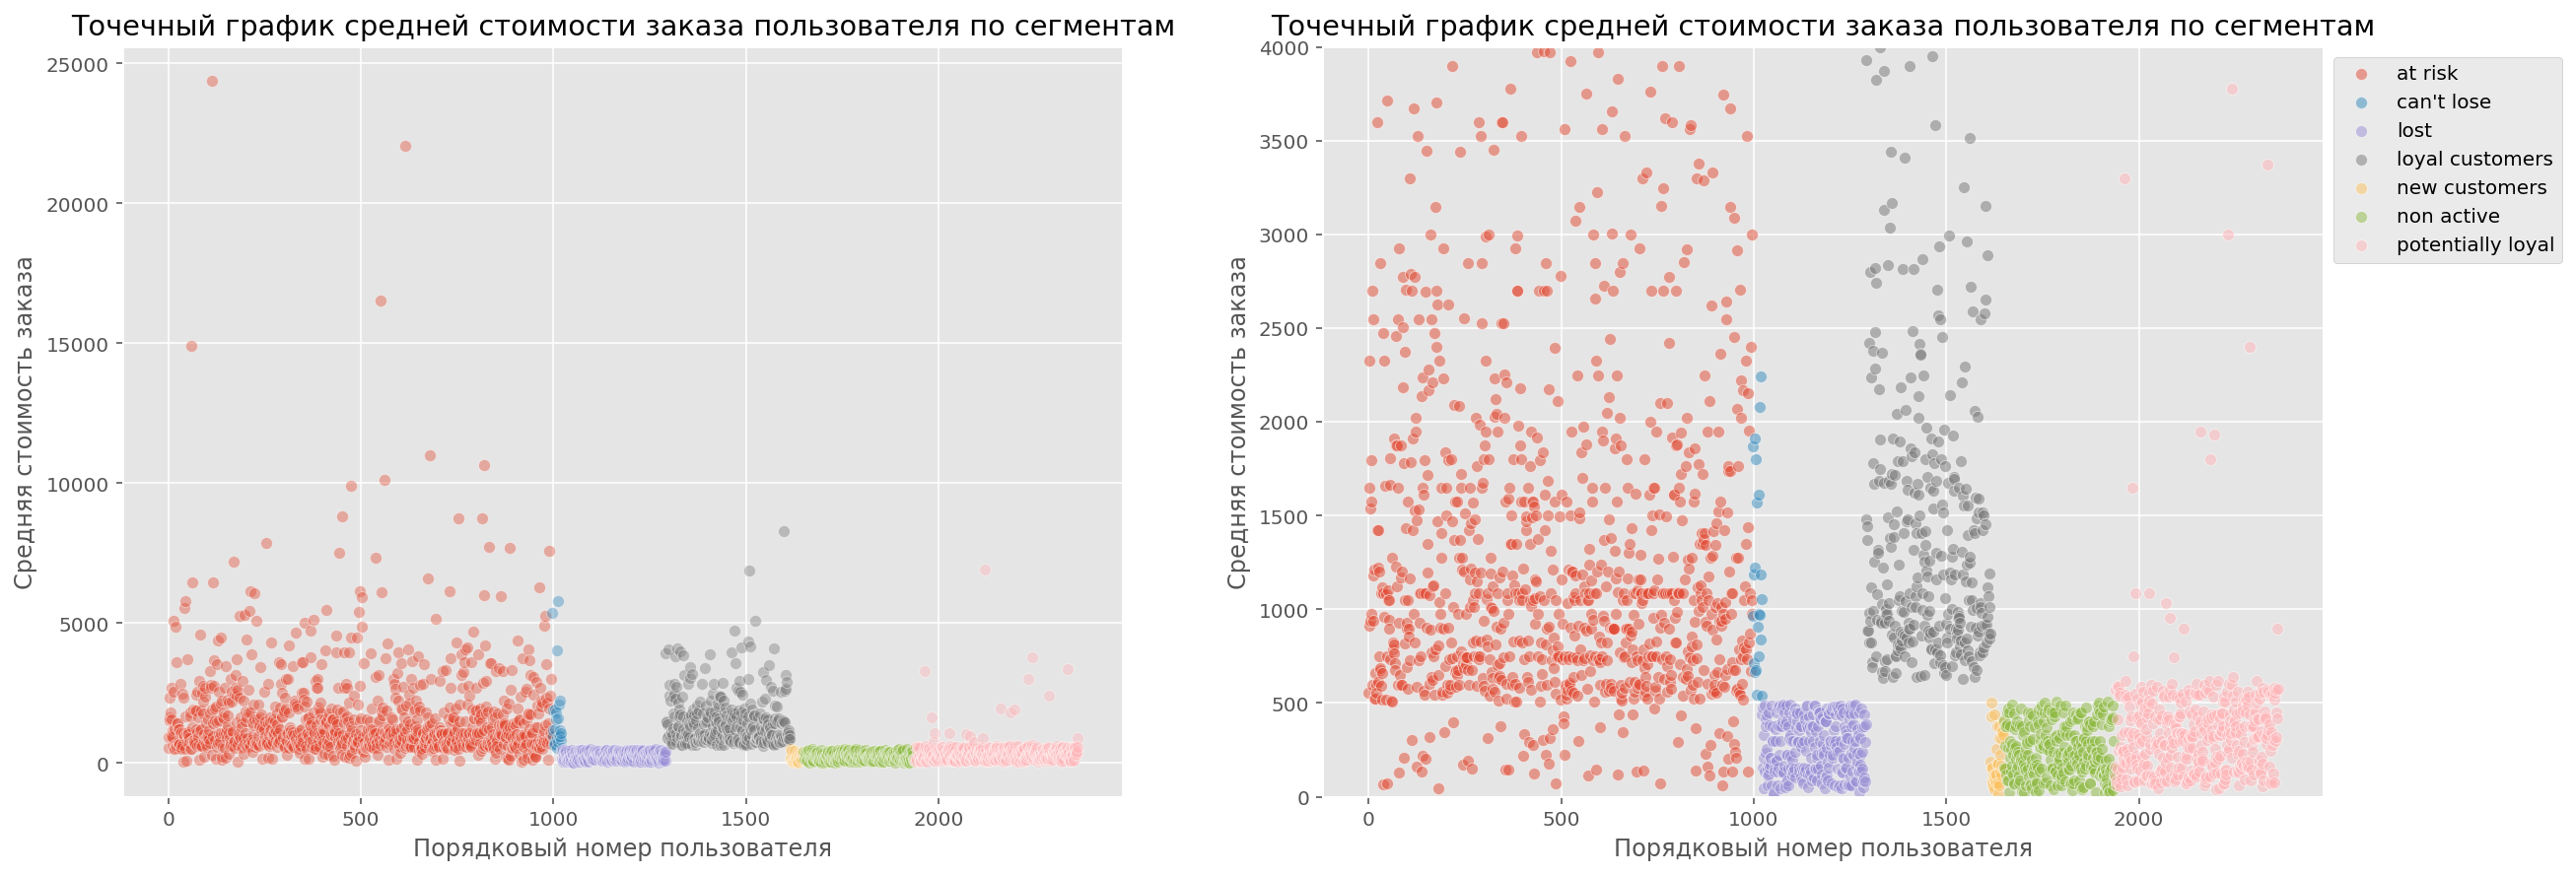

In [85]:
#построим точечную диаграмму среднего чека пользователя
figure, ax = plt.subplots(1,2,figsize=(20,7))
for cat in data_by_customers['segment'].unique():
    data_filtered = data_by_customers.query('segment == @cat')
    ax[0].set(title='Точечный график средней стоимости заказа пользователя по сегментам', xlabel='Порядковый номер пользователя', ylabel='Средняя стоимость заказа')
    sn.scatterplot(data_filtered.index, data_filtered['avg_revenue'], alpha = 0.4,ax=ax[0])
    ax[1].set(title='Точечный график средней стоимости заказа пользователя по сегментам', xlabel='Порядковый номер пользователя', ylabel='Средняя стоимость заказа')
    sn.scatterplot(data_filtered.index, data_filtered['avg_revenue'], alpha = 0.5, label=cat, ax=ax[1])
    plt.ylim(0,4000)
    plt.legend(bbox_to_anchor=(1, 1))
plt.show()

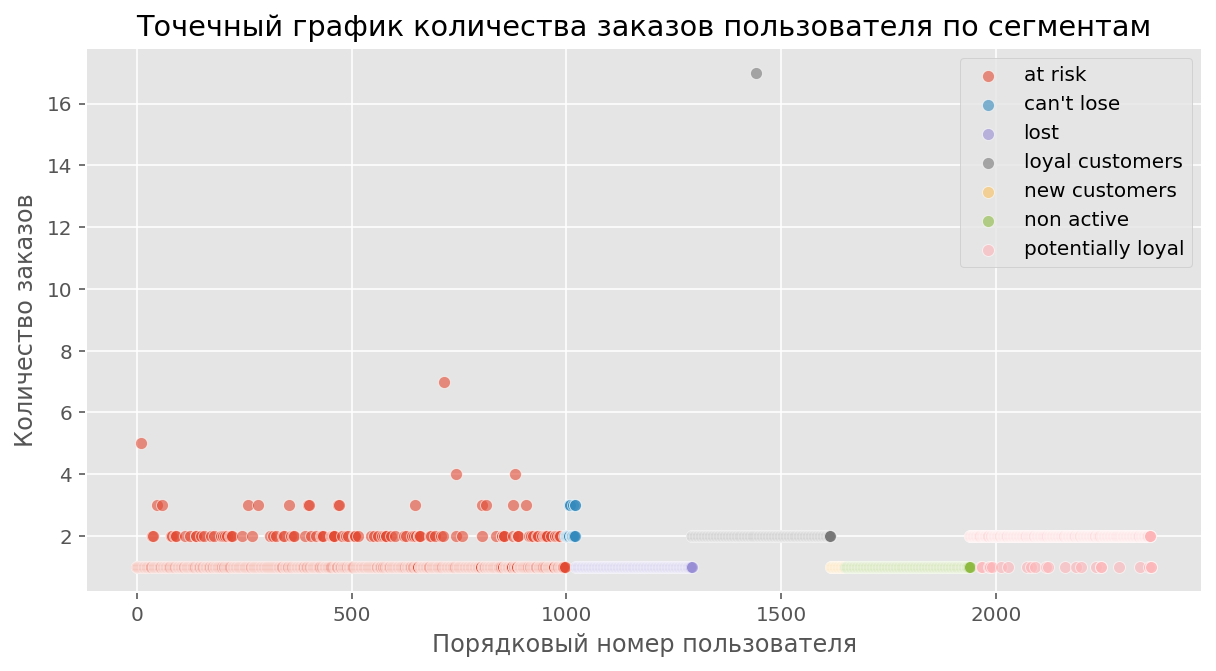

In [86]:
#построим точечную диаграмму заказов на пользователя
figure, ax = plt.subplots(figsize=(10,5))
for cat in data_by_customers['segment'].unique():
    data_filtered = data_by_customers.query('segment == @cat')
    ax.set(title='Точечный график количества заказов пользователя по сегментам', xlabel='Порядковый номер пользователя', ylabel='Количество заказов')
    sn.scatterplot(data_filtered.index, data_filtered['orders'], alpha = 0.6, label=cat)
    plt.legend(bbox_to_anchor=(1, 1))
plt.show()


В среднем для всех сегментов, за исключением лояльных покупателей и покупателей, которых мы не можем потерять, приходится по 1 заказу на пользователя. Лояльные покупатели и покупатели, которых мы не можем потерять, совершают минимум 2 заказа.

### Связь сегментов клиентов с категориями товаров




In [87]:
#посчитаем количество заказов для каждого сегмента по категориям товаров
customers_by_segment_category = data_segment.groupby(
    ['segment','category'], as_index=False).agg({'order_id':'nunique'}).sort_values(['category','order_id'],ascending=False)
#переименуем столбцы
customers_by_segment_category.columns = ['segment','category','orders']
customers_by_segment_category.head(10)

segment   category  orders
7             at risk  хозтовары     268
29    loyal customers  хозтовары     189
50  potentially loyal  хозтовары     162
42         non active  хозтовары      34
21               lost  хозтовары      33
14         can't lose  хозтовары      18
35      new customers  хозтовары       6
6             at risk   текстиль      92
28    loyal customers   текстиль      54
49  potentially loyal   текстиль      49

In [88]:
#отобразим распределение на графике
fig = px.bar(customers_by_segment_category, x='segment', y='orders', color='category', text='orders')
fig.update_layout(title='Распределение количества заказов в категории товаров по сегментам пользователей', yaxis_title='Сегмент', xaxis_title='Количество заказов', yaxis={'categoryorder': 'total ascending'})
fig.show()

Растения и хозтовары пользуются наибольшим спросом среди всех сегментов.

Посмотрим на средний чек пользователя в сегменте по категориям товаров



In [89]:
df_by_customers = data_segment.groupby(['segment','category','month','customer_id'], as_index=False).agg({'order_id':'nunique','revenue':'sum'})
df_by_customers.columns = ['segment','category','month','customer_id','orders','revenue']
df_by_customers['avg_revenue'] = df_by_customers['revenue']/df_by_customers['orders']
df_by_customers.sort_values('orders',ascending=False).head()

segment       category      month  \
2072  loyal customers      хозтовары 2019-10-01   
497           at risk       растения 2019-04-01   
1873  loyal customers  сумка-тележка 2019-10-01   
430           at risk       растения 2019-02-01   
69            at risk       для дома 2019-07-01   

                               customer_id  orders  revenue  avg_revenue  
2072  73d1cd35-5e5f-4629-8cf2-3fda829d4e58       7   5724.0   817.714286  
497   b7b865ab-0735-407f-8d0c-31f74d2806cc       4   3052.0   763.000000  
1873  73d1cd35-5e5f-4629-8cf2-3fda829d4e58       4  10572.0  2643.000000  
430   b7b865ab-0735-407f-8d0c-31f74d2806cc       3    660.0   220.000000  
69    6b0c6cfb-7717-4c34-8535-bbc6e2b2c758       3    660.0   220.000000

Посмотрим на средний чек всех пользователей по каждому сегменту по всем категориям товаров


In [90]:
avg_by_month = df_by_customers.groupby(by=['segment','category','month'],as_index=False).agg({'avg_revenue':'mean'})
avg_by_month.head()

segment  category      month  avg_revenue
0  at risk  для дома 2018-10-01  1115.000000
1  at risk  для дома 2018-11-01  2858.588235
2  at risk  для дома 2018-12-01  2054.571429
3  at risk  для дома 2019-01-01   426.125000
4  at risk  для дома 2019-02-01  1437.500000

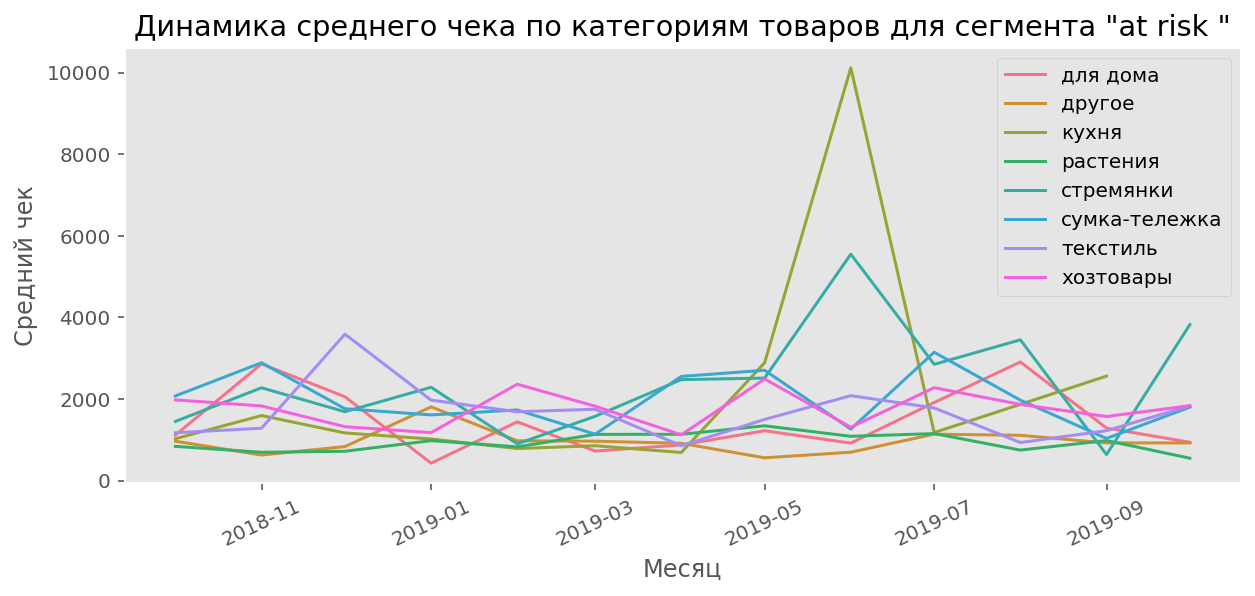

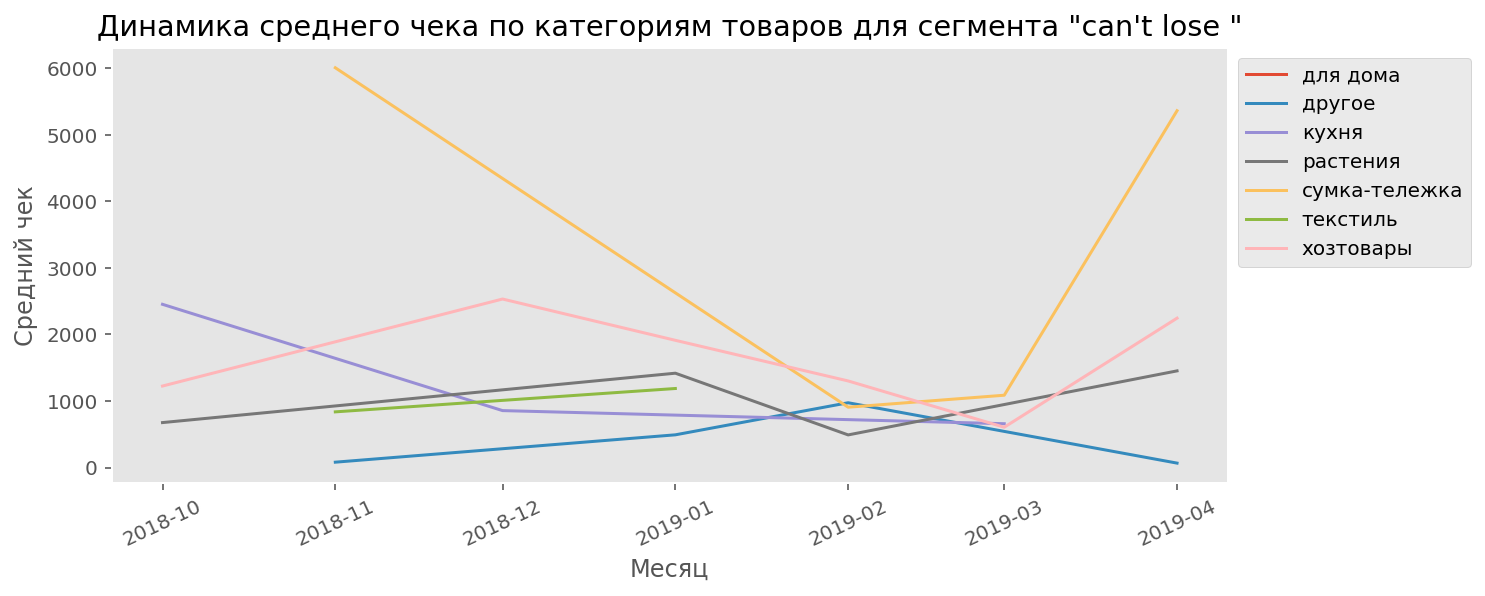

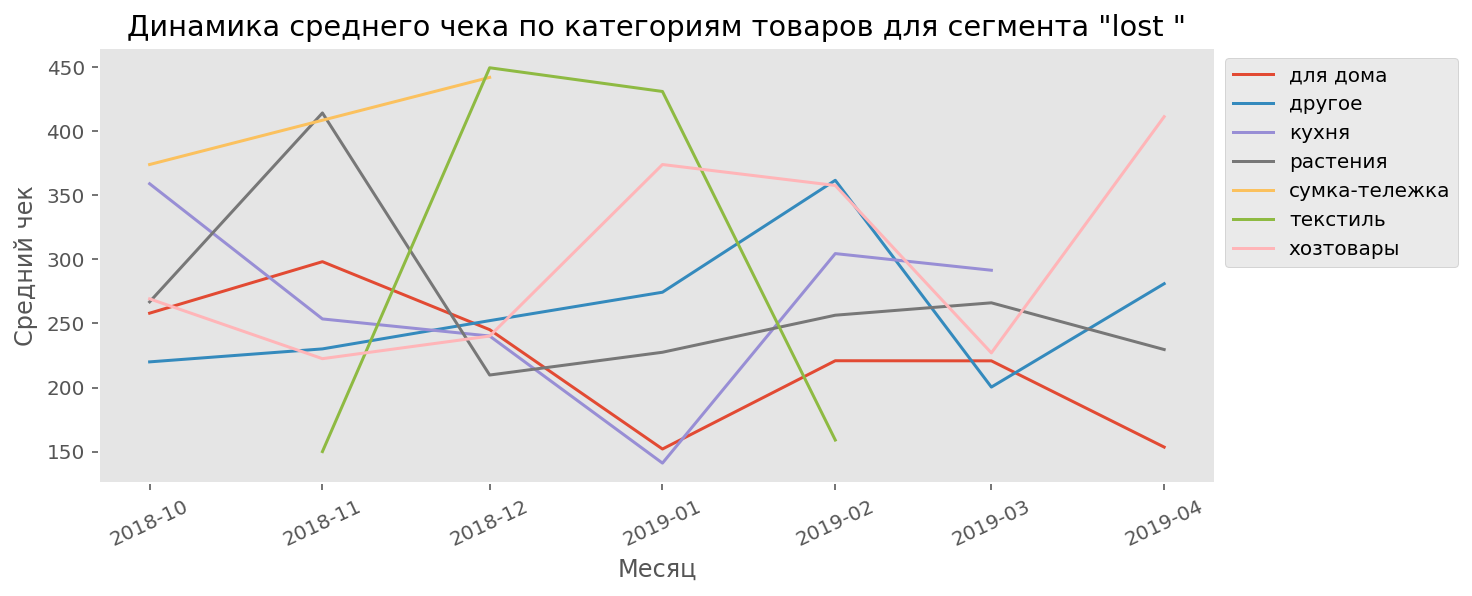

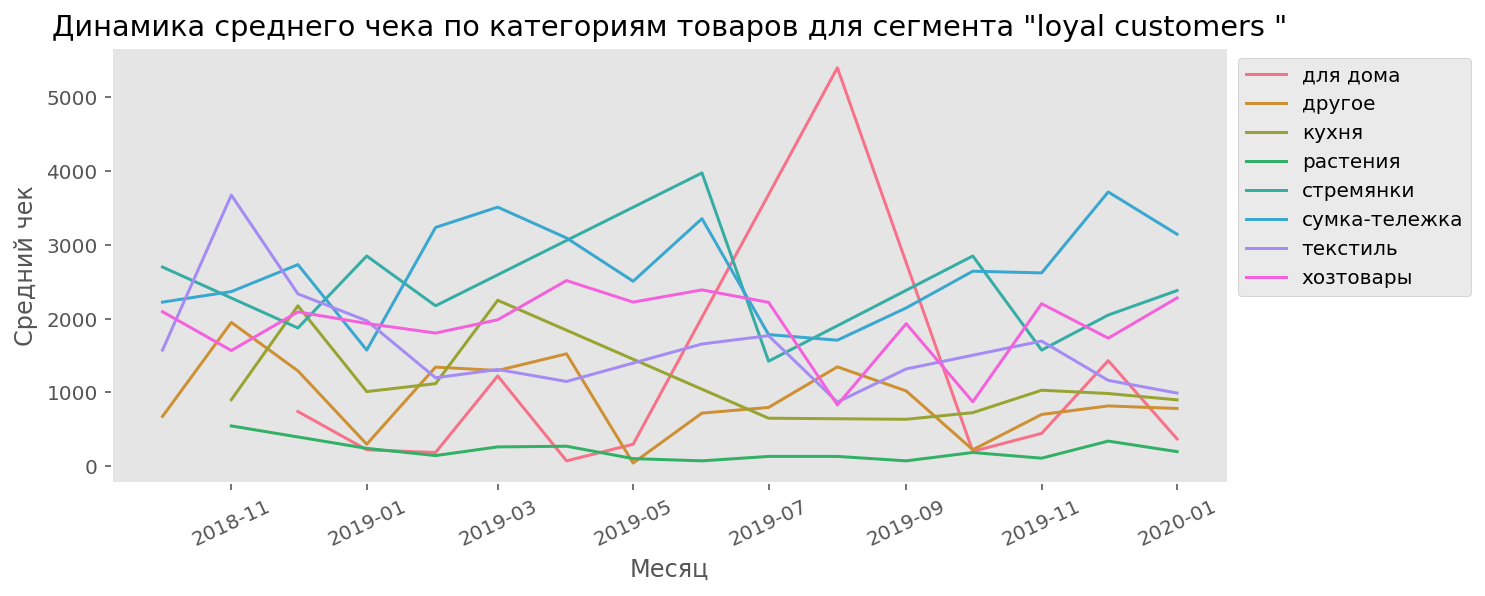

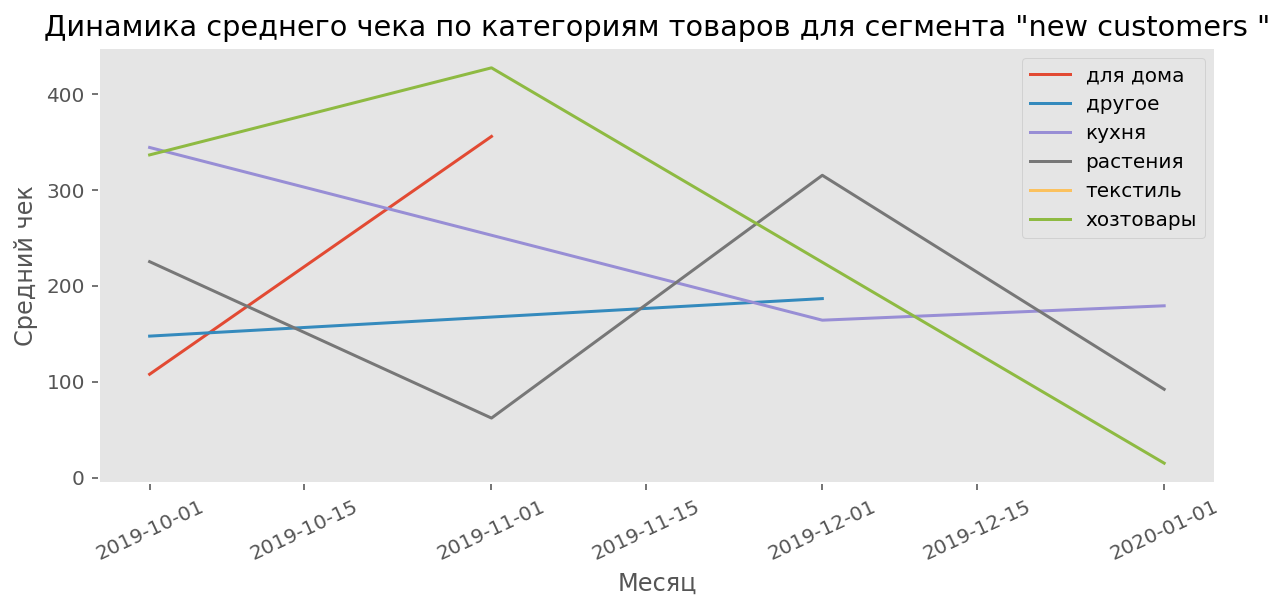

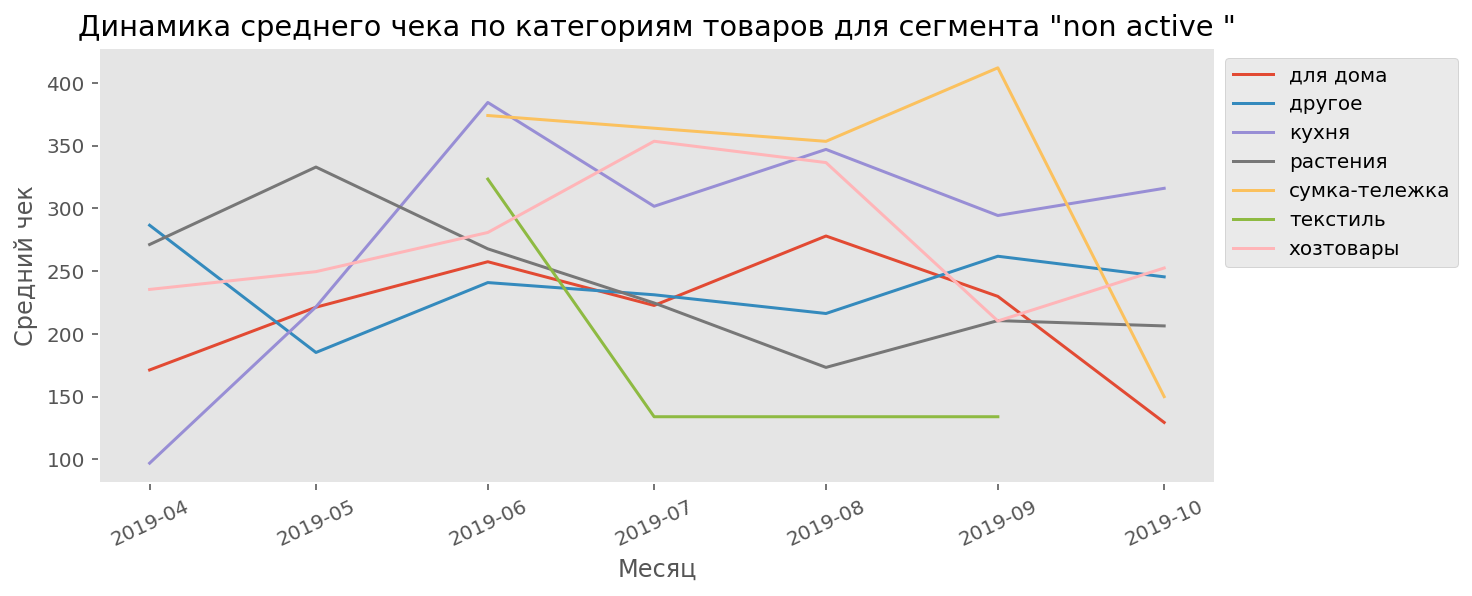

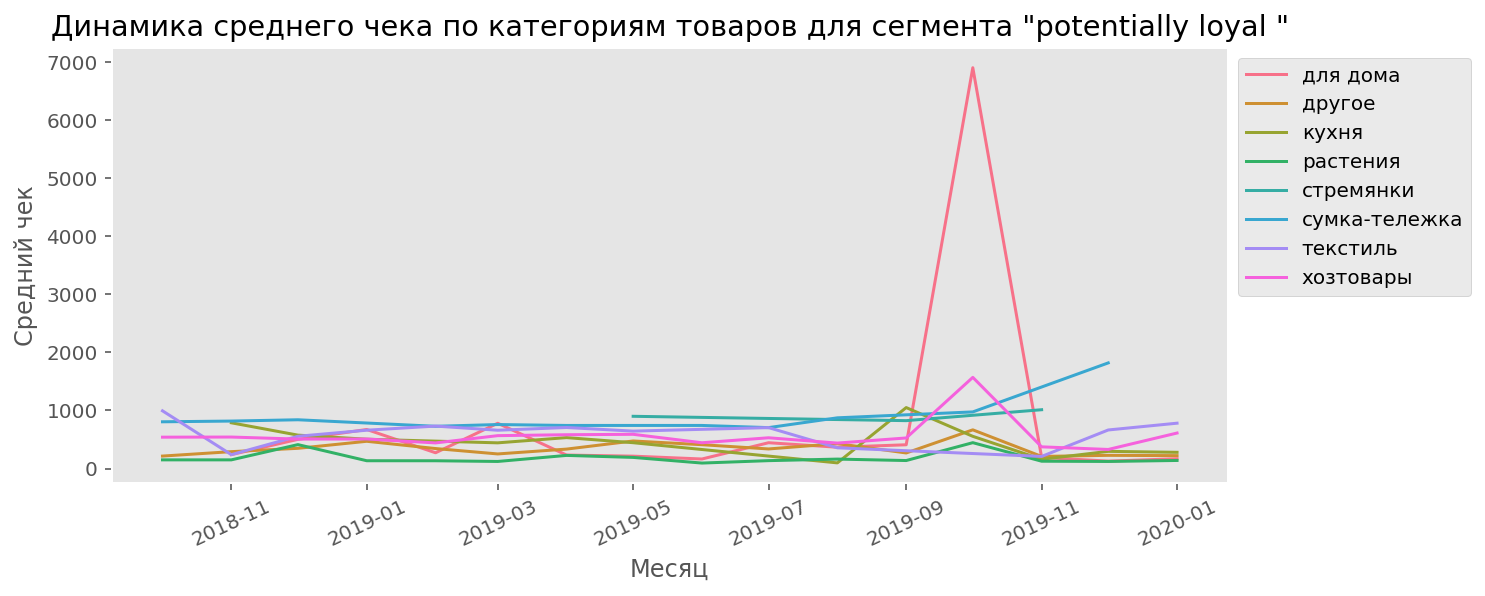

In [91]:
#строим графики
for seg in avg_by_month['segment'].unique():
    data_filtered = avg_by_month.query('segment == @seg')
    plt.figure(figsize=(10,4))
    plt.title(f'Динамика среднего чека по категориям товаров для сегмента \"{seg} \"')
    sn.lineplot(data=data_filtered,x='month', y='avg_revenue', hue='category')
    plt.grid()
    plt.xlabel('Месяц')
    plt.ylabel('Средний чек')
    plt.xticks(rotation = 25)
    plt.legend()
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

*Loyal customers*  имеют стабильный постоянный средний чек по категориям сумка- тележка и стремянки.  Категория Товары для дома имеют сезпнность с мая по октябрь. Практически не покупают растения. Спрос на хозтовары и товары для кухни стабилен. 
Следует развивать категорию товары для кухни и хозтовары в сегменте лояльных покупателей, чтобы повысить средний чек (представить больше позиций товаров, соответвующих запросам данных клиентов). Устроить информационную рассылку с акционными товарами для строительства и ремонта, чтобы повысть интерес лояльных пользователей к данной категории, а также периодически напоминать о поступлениях товаров данной категории, чтобы сделать спрос постоянным.

*Potentially loyal* стабильно низкий средний чек по всем категориям товаров. В октябре заметен всплеск интереса в категории товаров для дома, когра средний чек доходил до 7000 y.e. В конце 2019 года наблюдается интерес к сумкам- тележкам со стороны покупателей. Поэтому рекомендуeм обратить внимание на эту категорию - она имеет потенциал для развития. Разжигаем интерес пользователей информационными и акционными рассылками, возможно расширяем товарный ассортимент. Напоминаем пользователю о товарах в корзине или о товарах, которым они интересовались и снова поступили в продажу.

*At risk* имеют низкий средний чек по всем категориям. Категория стремянки показывет постоянное колебание, однако,
замечен тренд на увеличение среднего чека.  Категория товары для кухни имела всплеск продаж в июне, затем спад и небольшой подъем. Так как данные клиенты покупали часто, но давно  их стоит также попытаться вернуть - письмом с мотивацией к покупкe, рассылка с персональными скидками в этой категории, промокод на покупку и т. д.

*Can’t Lose* имеют постепенный спад и подъем в категориях хозтовары, сумка- тележка и растения. Покупатели данного сегмента перестали покупать товары категории текстиль аж с января. Разжигаем интерес пользователей информационными и акционными рассылками с персональными предложениями, предлагаем промокод на покупку, действительный в течение месяца. Напоминаем пользователю о товарах в корзине или о товарах, которым он интересовался и они снова поступили в продажу, напоминаем о важности клиента для нашего магазина. 


*New customer*  явно прослеживается тренд на снижение интереса по всем категориям. Возможно стоит устроить рекламную акцию, чтобы привлечь внимание новых пользователей к товарам для строительства и ремонта. Подогревать интерес акционными персональными рассылками. Устроить систему скидок для новых покупателей, чтобы удержать пользователя и перевести его в сегмент лояльного или потенциально лояльного покупателя.

*Non active* Средний чек по всем катвгориям балансирует на уровне 200-350 y.e. Eсть сезонность по товарам для кухни, дома и хозтоварам. Mаксимальный средний чек в категории сумка-тележка- 400 y.e. Клиенты данного сегмента почти не покупают текстиль,  что сильно меньше среднего чека лояльных и потенциально лояльных пользователей. Пытаемся привлечь внимание пльзователей информационными и акционными персонализированными рассылками, письмами с мотивацией к посещению магазина.

*Lost* максимальный средний чек в категориях сумка-тележка и текстиль - 400 y.e.- Важно отметить, что пользователи убежали в течение месяца.  Потерянные пользователи имеют средний чек в каждой категории товаров меньше 300 y.e, что сильно меньше значений в других сегментах. Попытаемся вернуть пользователей информационной рассылой с акцентом на важности клиента, акционной рассылка с персональными предложениями.

## Проверка гипотез
### Проверка гипотезы 1


Нулевая: различий в среднем чеке между сегментами нет.

Альтернативная: между сегменатми в среднем чеке есть статистически значимые различия.

Уровень значимости - 5%.

Критерий - непараметрический критерий Манна-Уитни st.mannwhitneyu(), так как он устойчив к выбросам. Это означает, что данные ранжируются, выброс будет просто распознаваться как случай, который ранжируется на единицу выше (или ниже) следующего наблюдения, поэтому сильного влияния на p-value выбросы не оказывают.

Так как между собой будут сравниваться 7 сегменов, то тест множественный (21 тест). При проведении множественного теста, чтобы снизить вероятность ошибки первого рода (нулевая гипотеза неверно отвергнута), необходимо применить поправку к уровню значимости. Будем использовать поправку Бонферрони - уровни значимости в каждом из m сравнений в m раз меньше, чем уровень значимости, требуемый при единственном сравнении.

In [92]:
# критический уровень статистической значимости
alpha = 0.05
#введем попарвку Бонферрони для множественного теста
bonferroni = 21
#статистический уровень значимости с учетом поправки
bonferroni_alpha = alpha / bonferroni

In [93]:
#функция для проведения теста - средний чек
def st_test(df,seg):

    for i in df['segment'].unique():
        if i not in seg:
            results = stats.mannwhitneyu(
            df[df['segment'] == seg[0]]['avg_revenue'],
            df[df['segment'] == i]['avg_revenue'])
            print(f'Проверка для сегментa {seg[0]} и {i}')
            print('p-значение: {0:.3f}'.format(results.pvalue))

            if results.pvalue < bonferroni_alpha:
                print('Отвергаем нулевую гипотезу: разница статистически значима')
            else:
                print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
                ) 
            print(' ')

In [94]:
st_test(data_by_customers, ['loyal customers'])


Проверка для сегментa loyal customers и at risk
p-значение: 0.001
Отвергаем нулевую гипотезу: разница статистически значима
 
Проверка для сегментa loyal customers и can't lose
p-значение: 0.616
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
 
Проверка для сегментa loyal customers и lost
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима
 
Проверка для сегментa loyal customers и new customers
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима
 
Проверка для сегментa loyal customers и non active
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима
 
Проверка для сегментa loyal customers и potentially loyal
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима
 


In [95]:
st_test(data_by_customers, ['potentially loyal','loyal customers'])


Проверка для сегментa potentially loyal и at risk
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима
 
Проверка для сегментa potentially loyal и can't lose
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима
 
Проверка для сегментa potentially loyal и lost
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима
 
Проверка для сегментa potentially loyal и new customers
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима
 
Проверка для сегментa potentially loyal и non active
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима
 


In [96]:
st_test(data_by_customers, ['at risk','potentially loyal','loyal customers'])


Проверка для сегментa at risk и can't lose
p-значение: 0.614
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
 
Проверка для сегментa at risk и lost
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима
 
Проверка для сегментa at risk и new customers
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима
 
Проверка для сегментa at risk и non active
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима
 


In [97]:
st_test(data_by_customers, ['can\'t lose','at risk','potentially loyal','loyal customers'])


Проверка для сегментa can't lose и lost
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима
 
Проверка для сегментa can't lose и new customers
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима
 
Проверка для сегментa can't lose и non active
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима
 


In [98]:
st_test(data_by_customers, ['new customers','can\'t lose','at risk','potentially loyal','loyal customers'])


Проверка для сегментa new customers и lost
p-значение: 0.006
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
 
Проверка для сегментa new customers и non active
p-значение: 0.056
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
 


In [99]:
st_test(data_by_customers, ['non active','new customers','can\'t lose','at risk','potentially loyal','loyal customers'])


Проверка для сегментa non active и lost
p-значение: 0.035
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
 


Oтвергнуть нулевую гипотезу о различии в среднем чеке между сегментами new customers и non active, new customers и lost, at risk и can't lose, potentially loyal и can't lose, potentially loyal и at risk, loyal customers и at risk, loyal customers и can't lose, loyal customers и potential loyalists не получилось. А значит статистически значимой разницы в среднем чеке между сегментами нет.

Для остальных групп сравнения разница статистически значима.

###  Проверка гипотезы 2 

Нулевая: различий в количестве заказов на пользователя между сегментами нет.

Альтернативная: между сегменатми в количестве заказов на пользователя есть статистически значимые различия.

Уровень значимости - 5%.

Критерий - непараметрический критерий Манна-Уитни st.mannwhitneyu(), так как он устойчив к выбросам. Это означает, что данные ранжируются, выброс будет просто распознаваться как случай, который ранжируется на единицу выше (или ниже) следующего наблюдения, поэтому сильного влияния на p-value выбросы не оказывают.

Так как между собой будут сравниваться 7 сегментов, то тест множественный. При проведении множественного теста, чтобы снизить вероятность ошибки первого рода (нулевая гипотеза неверно отвергнута), необходимо применить поправку к уровню значимости. Будем использовать поправку Бонферрони - уровни значимости в каждом из m сравнений в m раз меньше, чем уровень значимости, требуемый при единственном сравнении.

In [100]:
# критический уровень статистической значимости
alpha = 0.05
#введем попарвку Бонферрони для множественного теста
bonferroni = 21
#статистический уровень значимости с учетом поправки
bonferroni_alpha = alpha / bonferroni

In [101]:
#функция для проведения теста - количество заказов
def st_test_orders(df,seg):

    for i in df['segment'].unique():
        if i not in seg:
            results = stats.mannwhitneyu(
            df[df['segment'] == seg[0]]['orders'],
            df[df['segment'] == i]['orders'])
            print(f'Проверка для сегментa {seg[0]} и {i}')
            print('p-значение: {0:.3f}'.format(results.pvalue))

            if results.pvalue < bonferroni_alpha:
                print('Отвергаем нулевую гипотезу: разница статистически значима')
            else:
                print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')
            print('')

In [102]:
st_test_orders(data_by_customers, ['loyal customers'])


Проверка для сегментa loyal customers и at risk
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима

Проверка для сегментa loyal customers и can't lose
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима

Проверка для сегментa loyal customers и lost
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима

Проверка для сегментa loyal customers и new customers
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима

Проверка для сегментa loyal customers и non active
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима

Проверка для сегментa loyal customers и potentially loyal
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима



In [103]:
st_test_orders(data_by_customers, ['potentially loyal','loyal customers'])


Проверка для сегментa potentially loyal и at risk
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима

Проверка для сегментa potentially loyal и can't lose
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима

Проверка для сегментa potentially loyal и lost
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима

Проверка для сегментa potentially loyal и new customers
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима

Проверка для сегментa potentially loyal и non active
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима



In [104]:
st_test_orders(data_by_customers, ['at risk','potentially loyal','loyal customers'])


Проверка для сегментa at risk и can't lose
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима

Проверка для сегментa at risk и lost
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима

Проверка для сегментa at risk и new customers
p-значение: 0.031
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Проверка для сегментa at risk и non active
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима



In [105]:
st_test_orders(data_by_customers, ['can\'t lose','at risk','potentially loyal','loyal customers'])


Проверка для сегментa can't lose и lost
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима

Проверка для сегментa can't lose и new customers
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима

Проверка для сегментa can't lose и non active
p-значение: 0.000
Отвергаем нулевую гипотезу: разница статистически значима



In [106]:
st_test_orders(data_by_customers, ['new customers','can\'t lose','at risk','potentially loyal','loyal customers'])


Проверка для сегментa new customers и lost
p-значение: 1.000
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Проверка для сегментa new customers и non active
p-значение: 1.000
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя



In [107]:
st_test_orders(data_by_customers, ['non active','new customers','can\'t lose','at risk','potentially loyal','loyal customers'])


Проверка для сегментa non active и lost
p-значение: 1.000
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя



Статистически значимой разницы не обнаружено в количестве заказов на пользователя между сегментами can't lose и loyal customers не получилось. Данные группы клиентов совершают наибольшее количество заказов в магазине - среднее значение 2 (есть клиенты совершившие от 2 и более заказов).

Отвергнуть нулевую гипотезу о различии в количестве заказов на клиента между сегментами potential loyalists и at risk. Значит статистически значимой разницы в количестве заказов между сегментами нет. Данные сегменты совершают в среднем 1 заказ на клиента (но есть клиенты и с количеством заказов больше 2, хотя таких мало).

Статистически значимой разницы не обнаружно между сегментами about to sleep и lost, new customers и lost, new customers и about to sleep. Среднее значение количества заказов на пользователя для данных групп - 1.


## Выводы и Рекомендации







1. В имеющемся датасете проанализированы данные о 6 737 транзакциях в интернет-магазине товаров для дома и быта «Пока все ещё тут» с информацией о дате заказа, идентификаторах покупателей и заказов, наименованиях купленных товаров, количестве товара в заказе и его цене. 
 Анализируемый период с 1 октября 2018 года по 31 октября 2019 года. В данный промежуток покупки в интернет-магазине производил 2451 клиент, совершено 3521 заказов ( при этом в одном заказе могут быть товары разных категорий). Кроме того, один пользователь мог совершить несколько заказов в анализируемый период. 

В результате преобработки данных удалили аномальные заказы и дубликаты. Типы данных приведены к требуемым. Разделили ассортимент на категории по наименованию. 

2. В результате исследовательского анализа выяснили:

* Наибольшее количество уникальных товаров имеется в категории 'растения'	-714, на втором и третьем месте 'другое'- 503 и 'хозтовары' -384, затем  'декор дома'- 208. Остальные категории товаров имеют меньше 200 уникальных позиций.

* Наибольшую выручку принесли категории "хозтовары" и "сумка-тележка". 

* В каждой категории в среднем на пользователя приходится 1 заказ.

* Крупные заказы присутсвуют в категориях "стремянки" и "товары для кухни".

* По графикам динамики было выявлено, что тип продажи товаров стремянки и растения приходится с с марта по июнь, в то время как "товары для дома" и "товары для кухни" пользуются большей популярностью в зимний период времени. Остальные категории меньше подвержены сезонности и приносят в среднем постоянную выручку в каждый месяц.

* Заметен общий тренд на снижение суммарной выручки магазина на 15-20% (октября 2018 - октябрь 2019).

* Максимальное количество заказов наблюдается в период с февраля по апрель 2019 (примерно 250 заказов каждый месяц).

* Пик количества уникальных пользователей, как и пик количества заказов, приходится на февраль-апрель 2019. КОличество пользователей каждый месяц не опускается ниже 160.

3. При помощи RFM анализа (признаки: recency - давность покупки, и monetary - общая сумма покупок пользователя, по frequency - частота покупки) пользователли поделены на 7 сегментов. Описание сегментов представлено ниже.

Loyal Customers Покупают на регулярной основе. Отзывчивы к рекламным акциям.

Potentially loyal Недавние покупатели, со средней частотой покупок.

New customers  Покупали совсем недавно, но не часто.

Non active Давность и частота покупок ниже среднего. Вы потеряете их, если не активируете повторно.

At Risk Покупали на регулярной основе, но давно. Нужно вернуть их обратно

Can’t Lose  часто покупали, но долгое время не возвращались.

Lost Последняя покупка была давно и они не вернулись.

4. В ходе исследовательского анализа сегментов выяснили, что:
* Наибольшее количество пользователей имеется в сегменте "at risk" - 967, лояльных покупателей 323, а вот потенциально лояльных - 423, новых покупателей - 34, потерянных клиентов - 268. Неактивных- 286. 25 клиентов попали в сегмент "Can’t Lose".


* Лидер по среднему чеку сегмент "Loyal customers" - 2000 y.e..

* В среднем для всех сегментов, за исключением лояльных покупателей и покупателей, которых мы не можем потерять, приходится по 1 заказу на пользователя. Лояльные покупатели и покупатели, которых мы не можем потерять, совершают минимум 2 заказа.



Pекомендации по по сегментам и категориям:

"Товары для кухни" попали в тройку лидеров по количеству заказов в сегментах, данная категория имеет потенциал для роста - увеличить предлагаемый ассортимент.


Расширить ассортимент в категории "хозтовары" - найти более дешевые аналоги представленных товаров или найти поставщиков с более низкими ценами на уже представленные товары (тем самым предоставив клиенту более широкий выбор), чтобы привлечь большее число клиентов в этот сегмент, и тем самым, возможно, увеличить доходность категории.

В дачный сезон для всех сегментов устраивать рассылку с растениями и стремянками - это сезонный товар, и стоит акцентировать внимание покупателя на нем с марта по июнь.


   
   
Loyal customers имеют стабильный постоянный средний чек по категориям сумка- тележка и стремянки. Категория Товары для дома имеют сезoнность с мая по октябрь. 
Следует развивать категорию товары для кухни и хозтовары в сегменте лояльных покупателей, чтобы повысить средний чек (представить больше позиций товаров, соответвующих запросам данных клиентов). Устроить информационную рассылку с акционными товарами для строительства и ремонта, чтобы повысть интерес лояльных пользователей к данной категории, а также периодически напоминать о поступлениях товаров данной категории, чтобы сделать спрос постоянным.

Potentially loyal стабильно низкий средний чек по всем категориям товаров. В октябре заметен всплеск интереса в категории товаров для дома, когда средний чек доходил до 7000 y.e. В конце 2019 года наблюдается интерес к сумкам- тележкам со стороны покупателей. Поэтому рекомендуeм обратить внимание на эту категорию - она имеет потенциал для развития. Разжигаем интерес пользователей информационными и акционными рассылками, возможно расширяем товарный ассортимент. Напоминаем пользователю о товарах в корзине или о товарах, которым они интересовались и снова поступили в продажу.

At risk имеют низкий средний чек по всем категориям. Категория стремянки показывет постоянное колебание, однако, замечен тренд на увеличение среднего чека. Категория товары для кухни имела всплеск продаж в июне, затем спад и небольшой подъем. Так как данные клиенты покупали часто, но давно их стоит также попытаться вернуть - письмом с мотивацией к покупкe, рассылка с персональными скидками в этой категории, промокод на покупку и т. д.

Can’t Lose имеют постепенный спад и подъем в категориях хозтовары, сумка- тележка и растения. Покупатели данного сегмента перестали покупать товары категории текстиль аж с января. Разжигаем интерес пользователей информационными и акционными рассылками с персональными предложениями, предлагаем промокод на покупку, действительный в течение месяца. Напоминаем пользователю о товарах в корзине или о товарах, которым он интересовался и они снова поступили в продажу, напоминаем о важности клиента для нашего магазина.


New customer явно прослеживается тренд на снижение интереса по всем категориям. Возможно стоит устроить рекламную акцию, чтобы привлечь внимание новых пользователей к товарам для строительства и ремонта. Подогревать интерес акционными персональными рассылками. Устроить систему скидок для новых покупателей, чтобы удержать пользователя и перевести его в сегмент лояльного или потенциально лояльного покупателя.

Non active cредний чек по всем катвгориям балансирует на уровне 200-350 y.e. Eсть сезонность по товарам для кухни, дома и хозтоварам. Mаксимальный средний чек в категории сумка-тележка- 400 y.e. Клиенты данного сегмента почти не покупают текстиль, что сильно меньше среднего чека лояльных и потенциально лояльных пользователей. Пытаемся привлечь внимание пльзователей информационными и акционными персонализированными рассылками, письмами с мотивацией к посещению магазина.

Lost максимальный средний чек в категориях сумка-тележка и текстиль - 400 y.e.- Важно отметить, что пользователи убежали в течение месяца. Потерянные пользователи имеют средний чек в каждой категории товаров меньше 300 y.e, что сильно меньше значений в других сегментах. Попытаемся вернуть пользователей информационной рассылой с акцентом на важности клиента, акционной рассылка с персональными предложениями.
 